# Setup

Use below to reset all variables in the notebook

In [1]:
%reset -f
# list(globals())

Turn on autoreload functinality of modules imported into notebook.

In [2]:
%load_ext autoreload
%autoreload 2

## Tensorflow Setup


**TensorFlow ≥2.0 is required**

In [3]:
import tensorflow as tf

# tf.debugging.set_log_device_placement(True)

# Tensorflow requirement for this notebook
assert tf.__version__ >= "2.0"

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(f"Tensorflow version : {tf.__version__}")

Num GPUs Available:  4
Tensorflow version : 2.1.0


**Limit Tensorflow to a specific set of GPU's**

Physical GPU:0 is used by my OS for general rendering. 

First we get a list of all available physical GPU devices

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]

In [5]:
physical_gpus = tf.config.list_physical_devices('GPU')

if physical_gpus:
    # Restrict TensorFlow to not use the first GPU
    try:
        tf.config.set_visible_devices(physical_gpus[1:], 'GPU')
        
        logical_gpus = tf.config.list_logical_devices('GPU')
        
        print(len(physical_gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
        
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

4 Physical GPUs, 3 Logical GPU


Use below list of strings to access device string names later in notebook.

In [6]:
cpu = tf.config.list_logical_devices(device_type="CPU") 
gpu = tf.config.list_logical_devices(device_type="GPU")

cpu, gpu

([LogicalDevice(name='/device:CPU:0', device_type='CPU')],
 [LogicalDevice(name='/device:GPU:0', device_type='GPU'),
  LogicalDevice(name='/device:GPU:1', device_type='GPU'),
  LogicalDevice(name='/device:GPU:2', device_type='GPU')])

in below cell GPU actual refers to the logical device name

In [7]:
cpu[0].name, gpu[0].name

('/device:CPU:0', '/device:GPU:0')

## General Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [ ]:
# Standard Imports
import os
import sys
import warnings
from datetime import datetime
import itertools as it
import pandas as pd
import numpy as np
import pandas_datareader as pdr
from pandas import IndexSlice
from dateutil.relativedelta import relativedelta
import json

# Plotting
import plotly.express as px
import plotly.graph_objects as go
import cufflinks as cf
import matplotlib.pyplot as plt

# pd.options.plotting.backend = "plotly"  # this works for plotly >= 4.8 only
cf.set_config_file(offline=True)

# Others
import utils
%matplotlib inline

In [8]:
# Third Party Imports - CSV files stored locally so do not need this afterwards
from iexfinance import stocks
from iexfinance.refdata import get_symbols

## Global Variables and Functions

**NOTE**: ensure that below cells are run after wish you can skip to section 2.3 to read in saved csv data directly.

In [24]:
idx = IndexSlice
NP_RANDOM_SEED = utils.NP_RANDOM_SEED
TF_RANDOM_SEED = utils.TS_RANDOM_SEED
SKLEARN_RANDOM_SEED = utils.SKLEARN_RANDOM_SEED
PCLOSE = utils.PRICE_CLOSE
POPEN = utils.PRICE_OPEN
PHIGH = utils.PRICE_HIGH
PLOW = utils.PRICE_LOW
VOLUME = utils.VOLUME

RETURN = utils.RETURN
TARGET_COL = utils.TARGET_COL

DATA_DIR = os.path.join(os.getcwd(), "data")
IMAGES_DIR = os.path.join(os.getcwd(), "images")
MODELS_DIR = os.path.join(os.getcwd(), "models")
ROOT_LOG_DIR = os.path.join(os.getcwd(), "my_logs")

os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(IMAGES_DIR, exist_ok=True)

In [26]:

def get_symbol_list(force_api_call=False):
    """
    Retrieve a list of symbols / tickers for use in downloading each tickers
    respective historical / intraday data
    """
    _avail_symbols_fpath = os.path.join(DATA_DIR, "available_symbols.json")
    
    if force_api_call or not os.path.exists(_avail_symbols_fpath):
        print("Executing API call to retrieve available symbols\n")
        
        _avail_symbols = get_symbols(output_format='pandas')
        json.dump(_avail_symbols, open(_avail_symbols_fpath, "w"))
        
    else:
        print("Loading available symbols from json\n")
        _avail_symbols = json.load(open(_avail_symbols_fpath, "r"))

    # Convert to dataframe and set index to "symbol" / ticker
    df_symbols = pd.DataFrame(_avail_symbols).set_index("symbol")
    
    df_companies = df_symbols[
    df_symbols.name.str.contains("Momenta Pharmaceuticals") |
    df_symbols.name.str.contains("Zoetis")
    ]

    symbol_list = df_companies.index.to_list()
    
    return symbol_list

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_DIR, f"{fig_id}.{fig_extension}")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
    
def get_returns_data(df):
    
    # Calculate log returns
    df["return"] = np.log(df[PCLOSE]).diff().bfill()  
    # Note that first row will have a np.nan value due to above operation
    # Hence np.sign will generate RuntimeWarnings on this data
    
    # This is the change in price during a trading session itself, not between sessions/candles
    df["session_delta"] = df[PCLOSE] - df[POPEN]
    
    # Get sign of returns and session
    with warnings.catch_warnings():
        warnings.simplefilter(action="ignore", category=RuntimeWarning)
        
        df["return_sign"] = np.sign(df["return"]).replace(0, np.nan)
        df["return_sign"] = df["return_sign"].bfill()
        df["return_sign"] = (df["return_sign"] == 1).astype(np.int32)

        df["session_sign"] = np.sign(df["session_delta"]).replace(0, np.nan)
        df["session_sign"] = df["session_sign"].bfill()
        df["session_sign"] = (df["session_sign"] == 1).astype(np.int32)
   
    return df

# Data Retrivial

Retrieve Symbol(s)

In [28]:
symbol_list = get_symbol_list(force_api_call=False)
symbol_list

Loading available symbols from json



['MNTA', 'ZTS']

In [29]:
# User Settings
force_api_call = False

end = datetime(2020, 6, 15)
n_years = 5

start = end - relativedelta(end, years=n_years)

end, start

(datetime.datetime(2020, 6, 15, 0, 0), datetime.datetime(2015, 6, 15, 0, 0))

## Retrieve Asset(s) Data

Gather raw (uncleaned and augmented data) for the assets within the `symbol_list` and store in a dict.
```python
df_raw_dict = {
    symbol : DataFrame
}
```

In [30]:
# Dict to hold dataframe for each symbol
df_raw_dict = dict()

for symbol in symbol_list:
    
    # filepath to store data
    local_fpath = os.path.join(DATA_DIR, f"{symbol.strip('.-_:? ')}_raw_data.csv".lower())
    
    # keyword arguments called to api call
    kwargs = {
        "symbols":symbol, 
        "output_format":"pandas",
        "end":end,
        "start":start
    }
    
    # Retrieve data
    if not os.path.exists(local_fpath) or force_api_call:
        
        print(f"Using api call with kwargs: {kwargs}")
        # Get data and only extrace closing price column.
        # Must be a list of list to get DataFrame object rather than Series object
        _tmp_df = stocks.get_historical_data(**kwargs)  
        
        print(f"\nLocal csv filepath to write raw data to,\n\n>> {local_fpath}\n")
        _tmp_df.to_csv(local_fpath)
    
    else:
        
        print(f"Reading in data from,\n\n>> {local_fpath}\n")
        _tmp_df = pd.read_csv(local_fpath, parse_dates=True, index_col=0)
    
    # Join Fama-French Data
    # _tmp_df = _tmp_df.join(_tmp_df_ff)
    
    # df_raw_list.append(df_tmp)    # TODO: is this still required? or prefer using dict going foward?
    df_raw_dict[symbol] = _tmp_df

Reading in data from,

>> C:\Users\John\coding\python-user-notebooks\cqf\cqf_exams\project\data\mnta_raw_data.csv

Reading in data from,

>> C:\Users\John\coding\python-user-notebooks\cqf\cqf_exams\project\data\zts_raw_data.csv



### Remove NaN values

In [31]:
df_clean_dict = dict()

with pd.option_context("max_rows", 5):
    for symbol, df in df_raw_dict.items():
        
        df_clean_dict[symbol] = df.fillna(axis=0, method="ffill")
        
        print("-"*50, "\n", symbol)
        
        display(df_clean_dict[symbol])
        
    print("-"*50)

-------------------------------------------------- 
 MNTA


,open,high,low,close,volume
date,,,,,
2015-06-15,22.21,22.76,21.83,22.71,1022248
2015-06-16,22.75,22.94,22.48,22.63,625769
...,...,...,...,...,...
2020-06-11,31.68,32.30,30.55,30.61,997966
2020-06-12,30.15,31.69,29.64,31.05,913113


-------------------------------------------------- 
 ZTS


,open,high,low,close,volume
date,,,,,
2015-06-15,48.84,49.35,48.71,49.27,3014964
2015-06-16,49.30,49.73,48.90,49.71,1817939
...,...,...,...,...,...
2020-06-11,137.67,138.09,130.71,131.06,2523980
2020-06-12,134.37,136.21,131.31,134.07,1638539


--------------------------------------------------


Write / Load Cleaned Data

## Save Clean Data to CSV

In [126]:
for symbol, df in df_clean_dict.items():
    # filepath to store data
    local_fpath = os.path.join(DATA_DIR, f"{symbol.strip('.-_:? ')}_clean_data.csv".lower())
    print(f"\nLocal csv filepath to write cleaned data to,\n\n>> {local_fpath}\n")
    df.to_csv(local_fpath)


Local csv filepath to write cleaned data to,

>> C:\Users\John\coding\python-user-notebooks\cqf\cqf_exams\project\data\mnta_clean_data.csv


Local csv filepath to write cleaned data to,

>> C:\Users\John\coding\python-user-notebooks\cqf\cqf_exams\project\data\zts_clean_data.csv



## Read Clean Data from CSV

In [32]:
# Clean variables in memory using regex
%reset_selective -f "df[A-Za-a0-9]*"

In [33]:
_df_tmp_dict = dict()

symbol_list = get_symbol_list(force_api_call=False)

try:
    
    for symbol in symbol_list:
        
        local_fpath = os.path.join(DATA_DIR, f"{symbol.strip('.-_:? ')}_clean_data.csv".lower())
        
        print(f"Reading in data from,\n\n>> {local_fpath}\n")
        
        _df_tmp = pd.read_csv(local_fpath, index_col=0, parse_dates=True)
        
        _df_tmp_dict[symbol] = _df_tmp
        
except IOError as e:
    print(e)
else:
    print("Data succesfully read in.\n")
    df_clean_dict = _df_tmp_dict

Loading available symbols from json

Reading in data from,

>> C:\Users\John\coding\python-user-notebooks\cqf\cqf_exams\project\data\mnta_clean_data.csv

Reading in data from,

>> C:\Users\John\coding\python-user-notebooks\cqf\cqf_exams\project\data\zts_clean_data.csv

Data succesfully read in.



In [34]:
# Remove _tmp variables in memory using regex
%reset_selective -f "_tmp[A-Za-z]*"

**Ensure below is a DatetimeIndex**

In [35]:
df_clean_dict[symbol_list[0]].index

DatetimeIndex(['2015-06-15', '2015-06-16', '2015-06-17', '2015-06-18',
               '2015-06-19', '2015-06-22', '2015-06-23', '2015-06-24',
               '2015-06-25', '2015-06-26',
               ...
               '2020-06-01', '2020-06-02', '2020-06-03', '2020-06-04',
               '2020-06-05', '2020-06-08', '2020-06-09', '2020-06-10',
               '2020-06-11', '2020-06-12'],
              dtype='datetime64[ns]', name='date', length=1259, freq=None)

In [36]:
with pd.option_context("max_rows", 10, "max_columns", 10):
    display(df_clean_dict[symbol_list[0]].describe())

,open,high,low,close,volume
count,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03
mean,16.712867,17.160095,16.286148,16.735425,7.287712e+05
std,5.848477,6.041201,5.670205,5.867647,5.709444e+05
min,8.220000,8.340000,7.860000,8.210000,1.201490e+05
25%,12.500000,12.780000,12.145000,12.490000,4.297475e+05
50%,15.000000,15.330000,14.700000,15.000000,5.903120e+05
75%,18.895000,19.305000,18.475000,18.980000,8.590805e+05
max,34.980000,35.130000,33.270000,34.300000,8.482205e+06


Based on above count, when a sliding window with shift=1 is used, we should have 1258 unique sequences

# Naive Forecast

These are some simple experiments to form a baseline for comparison with a machine learning methods used later.

We first extract a dataframe from one of the symbols for use in our analysis and only the closing price is used.

In [37]:
df_exp_clean = df_clean_dict[symbol_list[0]].copy()
df_exp = df_exp_clean.copy()

# Generate additional data
get_returns_data(df_exp)

# Save the actual values for use later
y_actual = df_exp[TARGET_COL].copy() 

Now we make a naive forecast via predicting the same value as the previous time step

In [38]:
df_exp["naive_forecast"] = df_exp[TARGET_COL].shift(1).bfill().astype(np.int32)  #Note the use of the bfill here
df_exp[[TARGET_COL, "naive_forecast"]].head(5)

,return_sign,naive_forecast
date,,
2015-06-15,0,0
2015-06-16,0,0
2015-06-17,1,0
2015-06-18,1,1
2015-06-19,0,1


In [39]:
result = (df_exp[TARGET_COL] == df_exp["naive_forecast"]).astype(np.int32)

In [40]:
print("Accuracy = {:.2f}%".format(result.mean()*100))

Accuracy = 48.77%


So if we simply predicted the return sign to be the same as the previous period, we would be right ~ 48.77% of the time. \
We will now look at machine learning methods to determine if we can get an improved level of accuracy

# Machine Learning Data Preparation

Use `tf.data.Dataset` to generate a seqeuence of tensors

Note that when training, Tensorflow models expect each element in a Dataset to be a `tf.Tensor`\
and hence nested tf.data.Datasets should be avoided.

## Simple initial exploration steps

Just some simple steps to learn how tf.data.Datasets work and how we can generate a univariate sequence

In [43]:
dataset = tf.data.Dataset.range(6)
# Above is equiavalent to dataset = tf.data.Dataset.from_tensor_slices(np.arange(10))

utils.print_dataset(dataset)

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)


Now we create a sliding window to create a nested Dataset since each window is a Dataset itself consisting of "size" elements. \
Use drop remainder to remove windows whose size does not equal the full window size specified. \
If "shift=1" is not passed in then default is shift=window_size which is not what we want.

In [44]:
dataset = tf.data.Dataset.range(6).window(size=3, shift=1, drop_remainder=True)
utils.print_dataset(dataset, nested=True)

Window 0
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
Window 1
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
Window 2
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
Window 3
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)


I have found that the below is a good way to estimate the number of complete windows you have, but it is just an approximation. \
Tensorflow seems to do various things when size is larger than a certain fraction of number of elements.

$$
NC = \frac{(NE - Window) + 1}{Shift}
$$

where,
+ NC: Number of complete windows (drop_remainder=True)
+ NE: Number of elements in dataset originally
+ Window: size of the window
+ shift: amount by which window is shifted every time a new nested dataset of elements is created

In [45]:
# Each window is a Dataset itself, hence below structure is actually a nested Dataset.
dataset = tf.data.Dataset.range(10).window(size=5, shift=1, drop_remainder=True)

# Each window contains 5 elements. We call each window with its Dataset.batch() method to convert each
# window into a Dataset containing 1 element/sequence of length 5
# flat_map then unravels the nested elements of the main Dataset (which are the windows)
dataset = dataset.flat_map(lambda window: window.batch(5))

# We now split each element/sequence into a tuple of tensors.
# This is the format that the tensor flow model expect
dataset = dataset.map(lambda window: (window[:-1], window[-1]))
# We now have a dataset of shape [num_windows, window_size] for each of Tensors within the tuples/elements of the Dataset

# We use batch to create dataset of shape [num_bathces, batch_size, window_size]
batch_size = 2  # Training batch size
dataset = dataset.batch(batch_size).prefetch(1)

utils.print_dataset(dataset, nested=False, numpy_format=True)

--------------------
x =  [[0 1 2 3]
 [1 2 3 4]]
y =  [4 5]
--------------------
x =  [[2 3 4 5]
 [3 4 5 6]]
y =  [6 7]
--------------------
x =  [[4 5 6 7]
 [5 6 7 8]]
y =  [8 9]
--------------------


With shuffling this time to reduce sequence bias (shuffling to make X i.i.d)

In [46]:
dataset = tf.data.Dataset.range(10).window(size=5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1], window[-1]))

# Shuffle individual sequences
dataset = dataset.shuffle(buffer_size=10, seed=TF_RANDOM_SEED, reshuffle_each_iteration=False)

batch_size = 2  # Training batch size
dataset = dataset.batch(batch_size).prefetch(1)

utils.print_dataset(dataset, nested=False, numpy_format=True)

--------------------
x =  [[2 3 4 5]
 [5 6 7 8]]
y =  [6 9]
--------------------
x =  [[3 4 5 6]
 [4 5 6 7]]
y =  [7 8]
--------------------
x =  [[1 2 3 4]
 [0 1 2 3]]
y =  [5 4]
--------------------


Note the shape of each batch of the dataset

In [47]:
for x, y in dataset:
    print(x.shape, y.shape)

(2, 4) (2,)
(2, 4) (2,)
(2, 4) (2,)


## Preparing Machine Learning univariate time series dataset

Use a new Dataframe for the machine learning forecast to be generated in this section

In [48]:
df_ml_uv = df_clean_dict[symbol_list[0]].copy()
df_ml_uv.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2015-06-15 to 2020-06-12
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    1259 non-null   float64
 1   high    1259 non-null   float64
 2   low     1259 non-null   float64
 3   close   1259 non-null   float64
 4   volume  1259 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 59.0 KB


In [49]:
get_returns_data(df_ml_uv)

,open,high,low,close,volume,return,session_delta,return_sign,session_sign
date,,,,,,,,,
2015-06-15,22.21,22.76,21.83,22.71,1022248,-0.003529,0.50,0,1
2015-06-16,22.75,22.94,22.48,22.63,625769,-0.003529,-0.12,0,0
2015-06-17,22.70,23.00,22.48,22.88,844558,0.010987,0.18,1,1
2015-06-18,23.00,25.15,22.86,24.42,2820323,0.065139,1.42,1,1
2015-06-19,25.50,25.56,23.50,23.78,2364291,-0.026558,-1.72,0,0
...,...,...,...,...,...,...,...,...,...
2020-06-08,32.50,32.85,31.28,31.77,844097,-0.013755,-0.73,0,0
2020-06-09,31.28,34.25,31.11,33.36,832326,0.048835,2.08,1,1
2020-06-10,33.64,33.89,32.35,32.71,782212,-0.019677,-0.93,0,0


Check for NaN values

In [50]:
df_ml_uv.isna().sum()

open             0
high             0
low              0
close            0
volume           0
return           0
session_delta    0
return_sign      0
session_sign     0
dtype: int64

In [51]:
display(df_ml_uv)

,open,high,low,close,volume,return,session_delta,return_sign,session_sign
date,,,,,,,,,
2015-06-15,22.21,22.76,21.83,22.71,1022248,-0.003529,0.50,0,1
2015-06-16,22.75,22.94,22.48,22.63,625769,-0.003529,-0.12,0,0
2015-06-17,22.70,23.00,22.48,22.88,844558,0.010987,0.18,1,1
2015-06-18,23.00,25.15,22.86,24.42,2820323,0.065139,1.42,1,1
2015-06-19,25.50,25.56,23.50,23.78,2364291,-0.026558,-1.72,0,0
...,...,...,...,...,...,...,...,...,...
2020-06-08,32.50,32.85,31.28,31.77,844097,-0.013755,-0.73,0,0
2020-06-09,31.28,34.25,31.11,33.36,832326,0.048835,2.08,1,1
2020-06-10,33.64,33.89,32.35,32.71,782212,-0.019677,-0.93,0,0


In [52]:
def create_univariate_dataset(series, window_size, batch_size, shuffle_buffer):
    """
    Returns a dataset where each element is a tuple of (X, y) tensors.
    For each training instance X is a sequence and y is a scalar value, hence this is a sequence-vector ML problem
    
    param series:      Dataframe with 1 column or Series object
    param window_size: This Dropout be the number of elements that we will use as our features in each sequence
    param batch_size:  batch size of the tf.data.Dataset
    param shuffle_buffer: passed to tf.data.Dataset.shuffle()
    """
    overall_window = window_size + 1 # add extra 1 to sequence length to account for last value been target y
    
    depth = len(np.unique(series[:, 1]))
    
    # First we convert the series of values into a Dataset object
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data and then flatten the nested windows
    dataset = dataset.window(size=overall_window, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(overall_window))
    
    # Shuffle and use map to make each element of final Dataset a tuple of (X, y) 
    dataset = dataset.repeat(2)
    dataset = dataset.shuffle(shuffle_buffer, seed=TF_RANDOM_SEED, reshuffle_each_iteration=False)
    
    # Select PCLOSE for X and "return sign" for y
    dataset = dataset.map(lambda window: (window[:-1, 0, tf.newaxis], tf.one_hot(tf.cast(window[-1, 1], dtype=tf.int32), depth=depth) ) ) 
              
    
    # Create batches for mini-batch gradient descent
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

**Split Time Series**

Before creating the windowed dataset the time series needs to be split into train, validation and test sets. \
sklearn allows for a splitting into train and test, however to split into 3 separate datasets I will do this manually \
and demonstate this via use of a simple series of data first.

In [53]:
tmp = np.arange(10)
tmp

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [54]:
# Index of first split location
idx1 = int(0.5*10)

# Index of second split location
idx2 = int(idx1 + (0.2*10))

split_data = np.split(tmp, [idx1, idx2])
split_data

[array([0, 1, 2, 3, 4]), array([5, 6]), array([7, 8, 9])]

In [55]:
split_data[0].size/10, split_data[1].size/10, split_data[2].size/10

(0.5, 0.2, 0.3)

We can wrap the above operations into a function that takes in a 1D or 2D array and returns 3 separate arrays

In [56]:
def split_series(series, train_ratio, val_ratio):
    
    idx1 = int(len(series)*train_ratio)
    
    idx2 = idx1 + int(len(series)*val_ratio)
    
    train, val, test = np.split(series, [idx1, idx2])
    return train, val, test

Split the data

In [57]:
train_uv_series, val_uv_series, test_uv_series = split_series(df_ml_uv[[PCLOSE, "return_sign"]].squeeze().values, train_ratio=0.6, val_ratio=0.2)

Split the time / index

In [58]:
train_uv_time, val_uv_time, test_uv_time = split_series(df_ml_uv.index.values, train_ratio=0.6, val_ratio=0.2)

Check ratios

In [59]:
size = df_ml_uv.index.size
(
    round(train_uv_series.shape[0] / size, 3),
    round(val_uv_series.shape[0] / size, 3),
    round(test_uv_series.shape[0] / size, 3)
)

(0.6, 0.199, 0.201)

Convert the training univariate time series data into a tf.data.Dataset to be passed into models.

In [60]:
window_size = 30
batch_size = 32
shuffle_buffer = 100

# Training Dataset
train_uv_dataset = create_univariate_dataset(
    series=train_uv_series,
    window_size=window_size,
    batch_size=batch_size,
    shuffle_buffer=shuffle_buffer
)

# Validation Dataset
val_uv_dataset = create_univariate_dataset(
    series=val_uv_series,
    window_size=window_size,
    batch_size=batch_size,
    shuffle_buffer=shuffle_buffer
)

# Test Dataset
test_uv_dataset = create_univariate_dataset(
    series=test_uv_series,
    window_size=window_size,
    batch_size=batch_size,
    shuffle_buffer=shuffle_buffer
) 

Extract the labels as numpy arrays. This is not viable for data that does not fit into memory.

In [61]:
get_labels = lambda ds : np.array([i for i in ds.map(lambda x, y: y).unbatch().as_numpy_iterator()])
y_train_uv = get_labels(train_uv_dataset)
y_val_uv = get_labels(val_uv_dataset)
y_test_uv = get_labels(test_uv_dataset)

In [62]:
y_train_uv.shape, y_val_uv.shape, y_test_uv.shape

((1450, 2), (442, 2), (446, 2))

Quick check on the batches of training data and target values to confirm their shapes.

In [63]:
for X, y in train_uv_dataset:
    print(X.numpy().shape, y.numpy().shape)
    break

(32, 30, 1) (32, 2)


The target array is one-hot encodded with the labels being (0,1) correspondings to return signs of (-1, 1) respectively.

We can get number of batchs via calling list with the dataset and getting the length \
this is not a good thing to do in practice as the Dataset acts as an iterator and could be signifcantly long.

In [64]:
print("number of batchs = ", len(list(train_uv_dataset)))

number of batchs =  46


In [65]:
train_uv_dataset.element_spec

(TensorSpec(shape=(None, None, 1), dtype=tf.float64, name=None),
 TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))

The above states that each **element** of the training Dataset is a **()** tuple of length 2. Each element of the tuple is a Tensor \
as shown by **TensorSpec** and each Tensor is of dtype tf.float64. The first element is 2D and the second element is a 2D one-hot encoded array.

In [66]:
# Use value_type to see the type of value represented by the element spec
train_uv_dataset.element_spec[0].value_type, train_uv_dataset.element_spec[1].value_type

(tensorflow.python.framework.ops.Tensor,
 tensorflow.python.framework.ops.Tensor)

## Learning Rate Functions

When training the models we can also passing in a function that enables the learning rate to be adjusted as the number of epocs increases. \
This means we can start with a large learning rate initially and decrease it with further iterations. \
This section provides helper functions that themselves return a function that is passed into a Tensorflor callback to be called during training \
with an epoch and should return a new learning rate for the model.

In [69]:
def exponential_decay(lr0, s, decay=1.2, lr_min=None):
    """
    Learning rate gradually drops by a factor of 'decay' every 's' steps
    n(t) = n(0) * (1/decay)**(t/s)
    
    use lr_min to constrain the minimum learning rate
    """
    if lr_min:
        def _exp_decay_fn(epoch):
            return np.maximum(lr0 * (1/decay)**(epoch/s), lr_min)
    else:
        def _exp_decay_fn(epoch):
            return lr0 * (1/decay)**(epoch/s)
    return _exp_decay_fn


def power_schedule(lr0, s, c=0.25):
    """
    Learning rate drops at each step/epoch. 
    After s steps it is down to lr0/2
    After s more steps it i down to lr0/3
    etc
    This schedule first drops the learning rate quickly then more and more slowly.
    
    n(t) = n(0) / ( 1 + t/s)**c
    """
    def _power_fn(epoch):
        return lr0 / (1 + epoch/s)**c
    return _power_fn


In [76]:
def plot_learning_schedule(func, epochs=500):
    
    t = np.arange(epochs+1)
    y = func(t)
    fig = go.Figure(data=[go.Scatter(x=t, y=y)])
    
    fig.update_layout(xaxis=dict(title="epoch"), yaxis=dict(title="$\\alpha$", range=[0, np.max(y)]))
    fig.show()

The below cells illustrate how the learning rate decays with increasing epochs for exponential decay and for power scheduling.

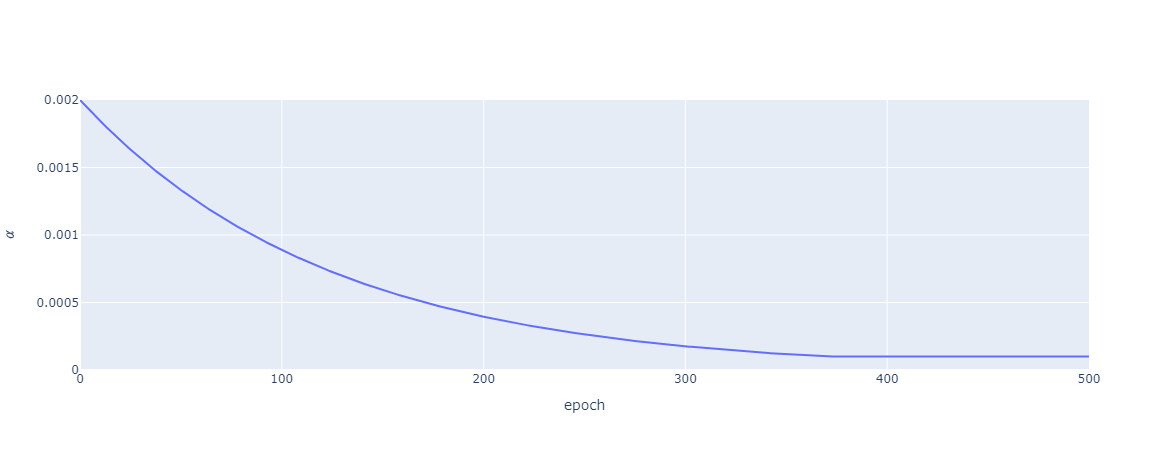

In [82]:
plot_learning_schedule(exponential_decay(lr0=2e-3, lr_min=1e-4, s=50, decay=1.5), epochs=500)

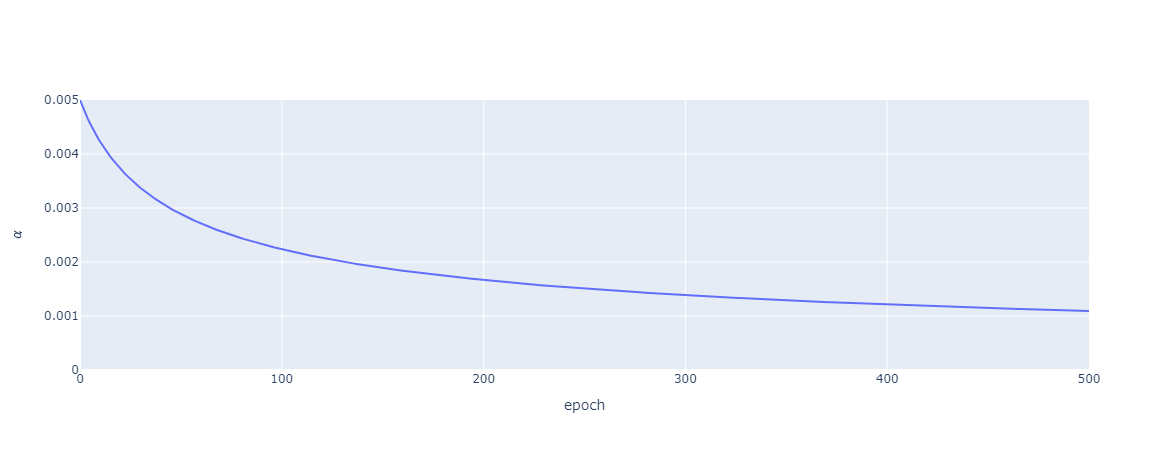

In [84]:
plot_learning_schedule(power_schedule(5e-3, s=25, c=0.5), epochs=500)

# Dense Neural Network

## Single Layer Neural Network 

We start with a single layer neural network and in following sections we incrementally increase the complexity of the neural networks.

Create a network with 1 hidden layer containing 1 neuron/unit and using a softmax activation function.

In [85]:
def get_simple_model(nx, ny):
    
    # You need this to ensure weights are initialized in a repeatable manner each time this cell is re-run
    tf.random.set_seed(TF_RANDOM_SEED)
   
    # Layers are numbered based on how they are accessed in model.layers[...]
    
    # Use Tensorflow Functional API to create Model
    inputs = tf.keras.Input(shape=[window_size, nx]) # Layer 0
    X = tf.keras.layers.Flatten()(inputs)           # Layer 1
    outputs = tf.keras.layers.Dense(units=ny, activation=tf.keras.activations.softmax)(X)  # Layer 2

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    return model

In [95]:
# Clear any previous graphs.
tf.keras.backend.clear_session()

# Train Model on a device
with tf.device(gpu[0].name):
    print("Training Started")
    
    # Obtain Model
    simple_model = get_simple_model(nx=1, ny=2)

    # Learning Rate Scheduling
    lr0 = 1e-4 # initial learning rate
    s = 25     # steps
    decay = 10 # factor by which learning rate falls over 's' steps
    
    lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay(lr0=lr0, s=s, decay=decay))
    
    # Optimizer used during 1 step of gradient descent
    optimizer = tf.keras.optimizers.SGD(lr=lr0, momentum=0.9)
    
    # The "loss" contains both crossentropy loss + regularization loss
    loss = tf.keras.losses.CategoricalCrossentropy()
    
    # Due to the use of regularization, we will monitor the categorical crossentropy as a metric aswell. 
    metrics = [
            tf.keras.losses.CategoricalCrossentropy(name="entropy"),
            tf.keras.metrics.CategoricalAccuracy(name='acc')
        ]
    
    # Compile Model
    simple_model.compile(
        loss=loss,   
        metrics=metrics,
        optimizer=optimizer
    )
    
    # Train Model
    simple_model_history = simple_model.fit(
        train_uv_dataset, 
        validation_data=val_uv_dataset, 
        epochs=100, 
        verbose=0,
        #callbacks=[lr_scheduler]
    )
    
    print("Training Completed")
    

Training Started
Training Completed


In [96]:
simple_model.metrics_names

['loss', 'entropy', 'acc']

In [97]:
result = simple_model.evaluate(train_uv_dataset, verbose=1)

result = pd.DataFrame(pd.Series(dict(zip(simple_model.metrics_names, result)), name="Training Results"))
result.loc["acc"] = (result.loc["acc"]*100)
result = result.round(5)
display(result)

     46/Unknown - 1s 12ms/step - loss: 0.7053 - entropy: 0.7053 - acc: 0.5393

,Training Results
loss,0.70526
entropy,0.70526
acc,53.93103


In [98]:
result = simple_model.evaluate(val_uv_dataset, verbose=0)

result = pd.DataFrame(pd.Series(dict(zip(simple_model.metrics_names, result)), name="Validation Results"))
result.loc["acc"] = (result.loc["acc"]*100)
result = result.round(5)
display(result)

,Validation Results
loss,0.77679
entropy,0.77679
acc,53.39367


Perform a quick check below to ensure metrics are correct

In [99]:
y_pred_uv = simple_model.predict(train_uv_dataset)  # predict() will ignore the labels in the Dataset and only use X.

y_train_uv.shape, y_pred_uv.shape

((1450, 2), (1450, 2))

'categorical_accuracy' can take in one-hot encoded labels and another matrix containing probabilities and return \
a 1D array containing 0 (False) and 1 (True) values to show if predicted categories were correct or incorrect.

In [100]:
acc = (tf.keras.metrics.categorical_accuracy(y_train_uv, y_pred_uv).numpy().mean())
print("Accuracy = {:.2f}%".format(acc*100))

Accuracy = 53.93%


In [101]:
simple_model_history.history.keys()

dict_keys(['loss', 'entropy', 'acc', 'val_loss', 'val_entropy', 'val_acc'])

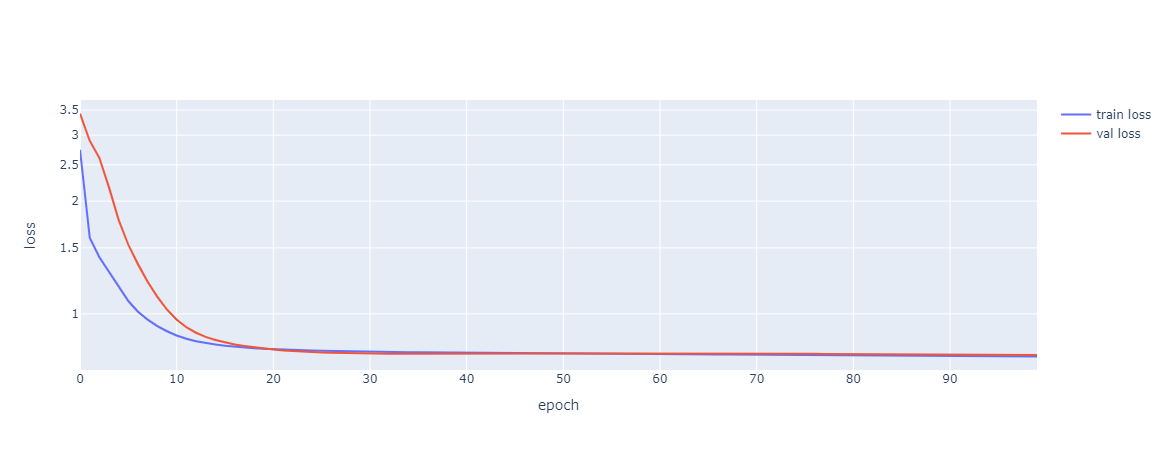

In [102]:
fig = go.Figure(data=[
    go.Scatter(x=simple_model_history.epoch, y=simple_model_history.history["loss"], name="train loss"),
    go.Scatter(x=simple_model_history.epoch, y=simple_model_history.history["val_loss"], name="val loss")
])

fig.update_layout(yaxis_type="log", xaxis=dict(title="epoch"), yaxis=dict(title="loss"))
fig.show()

inspect weights

In [103]:
weights, bias = simple_model.layers[2].get_weights()
print("Layer Bias", bias, "[1, n_neurons]")
print()
print("Weights shape = ", weights.shape)
print("Layer Weights\n", weights.T) # print transpose to same some space in output

Layer Bias [-0.03844796  0.03844796] [1, n_neurons]

Weights shape =  (30, 2)
Layer Weights
 [[ 0.13098253 -0.0925605  -0.24042302  0.32535803 -0.14447758 -0.0926432
  -0.21168602  0.21567863 -0.34030104  0.11364035  0.19357206 -0.27308917
   0.05648011 -0.08294317  0.1264378   0.20778257  0.1493579  -0.06381906
   0.28126267 -0.15350199 -0.28570348  0.25788295  0.15890226 -0.08402267
   0.08394358 -0.05755131  0.36034152 -0.11773925 -0.02850638  0.21537916]
 [-0.03955718 -0.06560607 -0.00350793  0.20513703 -0.33225036  0.120983
  -0.06435915  0.19507045 -0.06613087 -0.25751007  0.04480693  0.0862637
  -0.05888191 -0.07983224  0.12761861 -0.0466562   0.14347349 -0.18695056
   0.34020147  0.14933641  0.30247247 -0.22684498  0.23862636 -0.1309523
  -0.03315752  0.12044606  0.24618001  0.24698943 -0.2377719  -0.13144465]]


so shape is (window_size * dimensionality, n_neurons)

here dimensionality = 1 since this is a univariate time series.

X is of shape (m, window_size)

$$
\hat{Y} = g(X.W + b)
$$

where **g(...)** is a softmax activation providing logits as the output.

Finally we can calculate the accruacy on the test dataset to see how well our model generalizes.

In [104]:
result = simple_model.evaluate(test_uv_dataset, verbose=0)

result = pd.DataFrame(pd.Series(dict(zip(simple_model.metrics_names, result)), name="Test Results"))
result.loc["acc"] = (result.loc["acc"]*100)
result = result.round(5)
display(result)

,Test Results
loss,0.89790
entropy,0.89790
acc,50.22421


It appears it at least does better than the naive forecasting method that gave us an accuracy of ~49%, but not by a signifcant amount.

## Model Training and Evaulation Functions

Using the steps from the previous sub-section we can now create functions to enable us train and evaluate models in further sections.

In [128]:
def run_model(model, ds_train, ds_val, epochs=500, lr0=1e-3, s=50, decay=10, lr_min=None, verbose=1,
              loss=None, opt=None, metrics=None, callbacks=None, use_callbacks=True, comp=True):
    """
    General function for running a model
    
    ========================================================================================================================
    :param model:          tf.keras.models.Model object
    :param ds_train:       tf.data.Dataset with training data
    :param ds_val:         tf.data.Dataset with validation data
    :param epochs:         number of epochs for the model to run
    :param lr0:            learning rate schedule parameter
    :param s:              learning rate schedule parameter
    :param decay:          learning rate schedule parameter
    :param lr_min:         minimum learning rate for learning schedule to use.
    :param verbose:        controls output from model when training.
    :param loss:           loss function for model to use. Default os CategoricalCrossEntropy
    :param opt:            model optimizer. Default is Adam.
    :param metrics:        list of metrics for model to monitor. Default is CategoricalCrossEntropy and CategoricalAccuracy
    :param callbacks:      list of callbacks to use
    :param use_callbacks:  tf.keras.models.Model object 
    :param comp:           True if model is to be compiled/re-compiled, False of model should just be fit with data.
    ========================================================================================================================
    :return:               Tuple containing training history and trained model respectively.
    ========================================================================================================================
    """
    # Learning Rate Scheduling - uses Exponential Scheduling
    lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay(lr0=lr0, s=s, decay=decay, lr_min=lr_min))
    
    # Optimizer used during 1 step of gradient descent
    if not opt:
        optimizer = tf.keras.optimizers.Adam(lr=lr0, beta_1=0.9, beta_2=0.999)
    else:
        optimizer = opt
    
    # Note that the "loss" contains both crossentropy loss + regularization loss
    if not loss:
        loss = tf.keras.losses.CategoricalCrossentropy()
    
    # Due to the use of regularization in some models, we will monitor the categorical crossentropy as a metric aswell.
    if not metrics:
        metrics = [
                tf.keras.losses.CategoricalCrossentropy(name="entropy"),
                tf.keras.metrics.CategoricalAccuracy(name='acc')
        ]
            
    # Callbacks
    if use_callbacks:
        if callbacks:
            callbacks.extend(lr_scheduler)
        else:
            callbacks = [lr_scheduler]
    else:
        callbacks = None
            
    # Compile Model
    if compile:
        model.compile(
            loss=loss,   
            metrics=metrics,
            optimizer=optimizer
        )
    print("Training Started")
    # Train Model
    history = model.fit(
        x=ds_train, 
        validation_data=ds_val, 
        epochs=epochs, 
        verbose=verbose,
        callbacks=callbacks
    )
    print("Training Complete")
    return history, model

def run_model_uv(model, epochs=500, lr0=1e-3, s=50, decay=10, lr_min=None, verbose=1,
              loss=None, opt=None, metrics=None, callbacks=None, use_callbacks=True, comp=True):
    """
    Helper function for training only on the univariate dataset.
    """
    output = run_model(
        model=model, ds_train=train_uv_dataset, ds_val=val_uv_dataset,
        epochs=epochs, verbose=verbose, lr0=lr0, s=s, decay=decay, lr_min=lr_min, 
        loss=loss, opt=opt, metrics=metrics, 
        callbacks=callbacks, use_callbacks=use_callbacks, comp=comp)
    
    return output

In [125]:
def evaluate_model(model, train, val, test):
    """
    General function for evaluating a model on the training validation and test sets.
    ========================================================================================
    :param model:  tf.keras.models.Model object
    :param train:  tf.data.Dataset with training data
    :param val:    tf.data.Dataset with validation data
    :param test:   tf.data.Dataset with test data
    ========================================================================================
    :return:      Dataframe containing metrics for each dataset in its columns.
    ========================================================================================
    """
    def get_result(ds, name):
        result = model.evaluate(ds, verbose=0)
        result = pd.Series(dict(zip(model.metrics_names, result)), name=name)
        result.loc['acc'] = (result.loc['acc']*100)
        return result
    
    train_result = get_result(train, "Train")
    val_result = get_result(val, "Validation")
    test_result = get_result(test, "Test")
    
    df = pd.DataFrame([train_result, val_result, test_result]).T
    
    return df

def evaluate_model_uv(model):
    """
    Helpher function for evualting univariate datasets only
    """
    return evaluate_model(model, train_uv_dataset, val_uv_dataset, test_uv_dataset)

In [123]:
def plot_history(history, label="loss"):

    fig = go.Figure(data=[
        go.Scatter(x=history.epoch, y=history.history[label], name=f"train {label}"),
        go.Scatter(x=history.epoch, y=history.history[f"val_{label}"], name=f"val {label}")
    ])
    
    fig.update_layout(xaxis=dict(title="epoch"), yaxis=dict(title="$\\alpha$"))
    fig.update_layout(yaxis_type="log")
    fig.show()

## Deep Neural Network

Now we try a deep Neural network with multiple layer and multiple neurons per layer. \
The shape of the weights matrix in this case should be

$[T_{x} \times dimensionality, n^{[l]}]$

In [111]:
def get_dnn_model(nx, ny):
    
    # Always set seed first as this will affect weight initialization and hence trained model parameters
    tf.random.set_seed(TF_RANDOM_SEED)
    
    inputs = tf.keras.layers.Input(shape=[window_size, nx])
    X = tf.keras.layers.Flatten()(inputs)
    X = tf.keras.layers.Dense(20, activation=tf.nn.elu)(X)
    X = tf.keras.layers.Dense(10, activation=tf.nn.elu)(X)
    X = tf.keras.layers.Dense(5, activation=tf.nn.elu)(X)
    outputs = tf.keras.layers.Dense(ny, activation=tf.nn.softmax)(X) 
    
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    
    return model

In [129]:
tf.keras.backend.clear_session()

with tf.device(gpu[0].name):
    
    dnn_model = get_dnn_model(nx=1, ny=2)

    dnn_history, dnn_model = run_model_uv(dnn_model, epochs=500, lr0=1e-3, s=100, decay=10, verbose=0)

Training Started
Training Complete


In [130]:
dnn_history.history.keys()

dict_keys(['loss', 'entropy', 'acc', 'val_loss', 'val_entropy', 'val_acc', 'lr'])

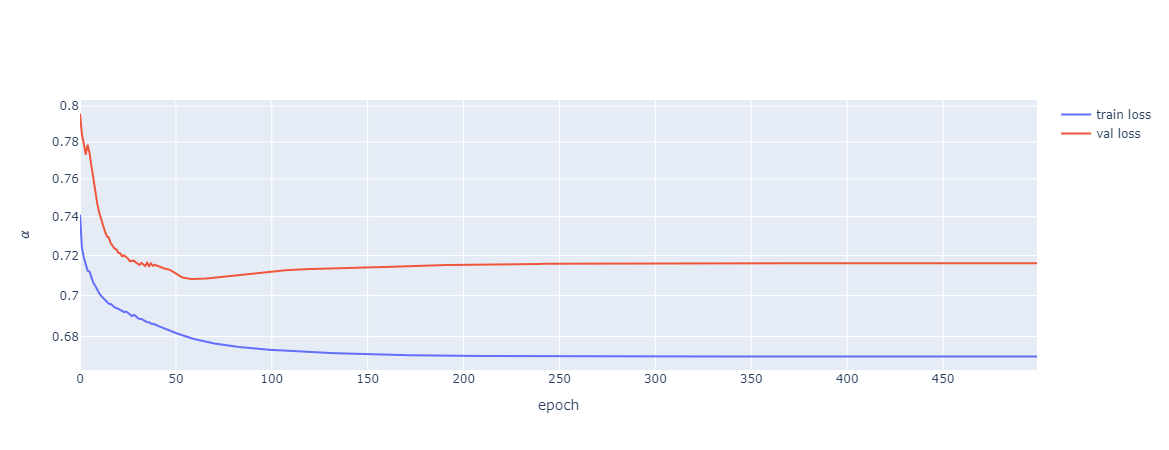

In [131]:
plot_history(dnn_history, label="loss")

What is important to note in the above figure is that the validation loss is significantly higher than the training loss. \
This suggests that the model is overfitting to the training data and hence some form of regularization will be needed. \
However, this was just to illustrate how a Deeper network could perform and I will not continue this model further.

In [132]:
evaluate_model_uv(dnn_model)

,Train,Validation,Test
loss,0.669200,0.716052,0.852412
entropy,0.669200,0.716052,0.852412
acc,58.206898,52.036202,52.017939


The deep neural network performs better than the single layer, single neuron network; both on the training and test dataset.

# Recurral Neural Networks
A - activation \
Z - linear output from neurons \
W - Weights matric \
b - bias term

$
W_{ax} - [dimensionality, n_{neurons}]
$
+ a - this W is used to calculate an "a" like quantity.
+ x - this W is multiplied (dot product) with an $X^{t}$ like quantity.

$
W_{aa} - [n_{neurons}, n_{neurons}]
$
+ a - this W is used to calculate an "a" like quantity.
+ x - this W is multiplied (dot product) with an "a" like quantity.

$
W_{ya} - [n_{neurons}, num_{classes}]
$
+ a - this W is used to calculate an "y" like quantity.
+ x - this W is multiplied (dot product) with an "a" like quantity.

## Simple RNN


**Forward Propagation**

Only uses information from **earlier** in the sequence to make prediction for $\hat{y}^{<t>}$.

$$
a^{<t>} = g_{1}\left(a^{<t-1>} W_{aa} + X^{<t>} W_{ax} + b_a \right)
$$

where $g_{1}()$ can be either tanh/relu activation function

$$
\hat{y}^{<t>} = g_{2}\left( a^{<t>} W_{ya} + b_y \right)
$$

where $g_{2}()$ is a sigmoid/softmax for classification or a function that returns its input unchanged for a regression problem. \
It is essentially a Dense layer.


**Alternative Notation**
$$
a^{<t>} = g_{1}\left( W_{a} [a^{<t-1>}, X^{<t>}] + b_a \right)
$$

Matrices can be stacked to reduce the number of computations required,

$a^{<t-1>}$ has shape [m, n_neurons] \
$X^{<t>}$ has shape [m, dimensionality]

Hence they have the same number of rows and different number of columns, \
these can be **column stacked** to produce a matrix of shape $[m, (n_{neurons} + dims)]$.

The weight matrics can then be **row stacked** to give a single weight matrix ($W_a$) of shape $[(n_{neurons} \times dims), n_{neurons}]$.

**Back Propagation Through Time**

Cost functon is a sum of loss across each time step

The loss at each time step Ty (note how this is using output sequence length and not input sequence length Tx)
$$
L^{<t>}(\hat{y}^{<t>}, y^{<t>}) = -y^{<t>}\log{\hat{y}^{<t>}} - (1 - y^{<t>})\log{\hat{y}^{<t>}}
$$

Total loss is then given by the sum of all element wise losses.
$$
L(\hat{y}, y) = \sum_{t=1}^{T_y} L^{<t>}(\hat{y}^{<t>}, y^{<t>})
$$

Cost function derivative is computed for every output/predicted value then summed across all time steps and along all training instances.

**Other** \
Full input shape = [batch_size, Tx, dims]

In [154]:
def get_simple_rnn_model(nx, ny):
    
    tf.random.set_seed(TF_RANDOM_SEED)
    
    l2 = tf.keras.regularizers.l2(0.01)
    
    inputs = tf.keras.layers.Input(shape=[None, nx])
    X = tf.keras.layers.SimpleRNN(24, kernel_regularizer=l2, return_sequences=True)(inputs)
    X = tf.keras.layers.SimpleRNN(12, kernel_regularizer=l2, return_sequences=False)(X)
    outputs = tf.keras.layers.Dense(ny, activation=tf.nn.softmax)(X)
    
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

    return model

In [155]:
tf.keras.backend.clear_session()

with tf.device(gpu[0].name):
   # 2e-3, s=50, decay=1.1, lr0=1e-3, s=5, decay=10
    srnn_model = get_simple_rnn_model(1, 2)
    
    srnn_history, srnn_model = run_model_uv(srnn_model, epochs=200, lr0=2e-3, s=50, decay=1.1, use_callbacks=True, verbose=0)

Training Started
Training Complete


In [156]:
srnn_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 1)]         0         
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, None, 24)          624       
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 12)                444       
_________________________________________________________________
dense (Dense)                (None, 2)                 26        
Total params: 1,094
Trainable params: 1,094
Non-trainable params: 0
_________________________________________________________________


In [157]:
srnn_model.metrics_names

['loss', 'entropy', 'acc']

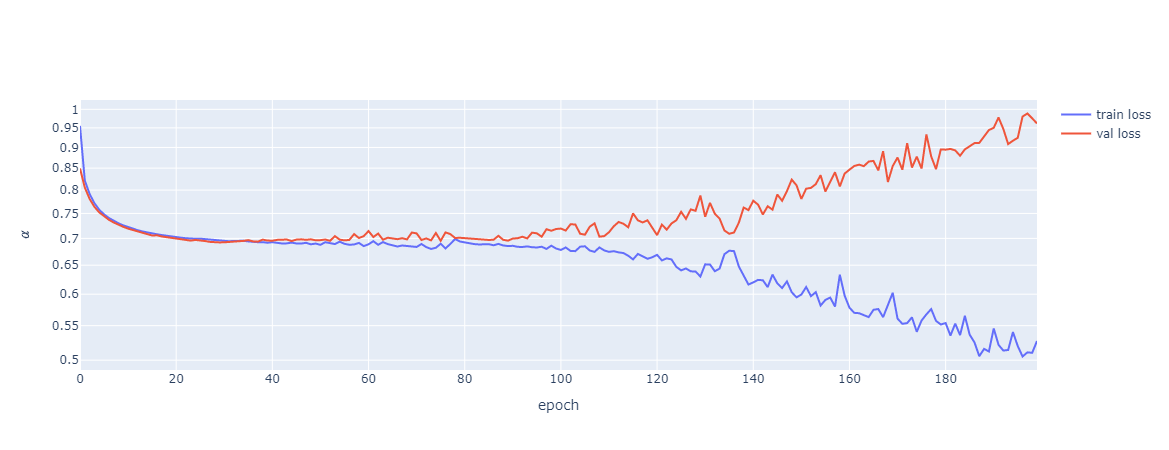

In [158]:
plot_history(srnn_history, label="loss")

The model was trained with very little regularization and the above figure shows that initially the training and validation loss went down togther, \
however at approximately 30 epochs the validation loss started to increase while training loss continued to decrease.

In [159]:
evaluate_model_uv(srnn_model)

,Train,Validation,Test
loss,0.493498,0.961586,1.035173
entropy,0.477196,0.945283,1.018871
acc,77.103448,50.678736,49.327356


The RNN performs well on the training data but generalizes very poorly to the validation and test datasets. This model is overfitting significantly and \
more regularization and increased training data will be needed.

## Simple LSTM Model


**GRU Cell**

It is easier to first illustrate and explain the Gated Recurrent Unit before showing how the LSTM Cell works.

<br>

+ $c^{<t>}$ = memory cell state, shape of $[m, n_{neurons}]$ (same shape as $a^{<t>}$). \
The GRU will output a memory state that is equal to the activation **from** this cell, i.e. $c^{<t>}$ = $a^{<t>}$

+ $\tilde{c}^{<t>}$ - candidate cell state. Candidate for replacing $c^{<t>}$, computed using previous memory cell state from earlier in sequence.

$$
\tilde{c}^{<t>} = \tanh(W_c [\Gamma_r * c^{<t-1>}, x^{<t>}] + b_c)
$$

where $\Gamma_r$ is the "relevance" gate.

+ $\Gamma_r$ - "relevance" gate, with values between 0 and 1. It is how relevant $c^{<t-1>}$ is for calculating the new candidate value $\tilde{c}^{<t>}$,

$$
\Gamma_r = \sigma \left(W_r [c^{<t-1>}, x^{<T>}] + b_r \right)
$$

+ $\Gamma_u$ - update gate, with values between 0 and 1. This value decides when we update $c^{<t>}$ with its candidate value $\tilde{c}^{<t>}$,

$$
\Gamma_u = \sigma \left(W_u [c^{<t-1>}, x^{<T>}] + b_u \right)
$$


So we now have 6 parameters to be learnt in this cell; technically there are 9, but we can contact some matrices as shown ealier to reduce this to 6.
+ $W_c$ and $b_c$ for calculating the candidate cell state with a tanh activation function (values between -1 and 1)
+ $W_r$ and $b_r$ for calculating the relevance gate with a sigmoid activation function (values between 0 and 1)
+ $W_u$ and $b_u$ for calculating the update gate with a sigmoid activation function (values between 0 and 1)

The cell state to be output from this layer is thus calculated as,

$$
c^{<t>} = \Gamma_u \tilde{c}^{<t>} + (1 - \Gamma_u)c^{<t-1>}
$$

Notice how the above looks very similar to an EWMA where the learned coefficient $\Gamma_u$ controls how back in the sequence the EWMA decays to zero. 

$$
v(t) = \beta v(t-1) + (1-\beta) \theta(t)
$$

From this we can see that $c^{<t>}$ contrains information from the current time step and for $\frac{1}{1- \Gamma_u}$ periods within the sequence aswell.
+ for $\Gamma_u = 0.1$ this is equivalent to $\beta = 0.9$ and this gives a 10 period EWMA. 
+ for $\Gamma_u = 1$ this is equivalent to $\beta = 0$ and this uses no previous history and reverts to a simple RNN. 

**LSTM Cell**

The LSTM is a more generalized and complex version of the GRU. It uses more gates and the cell state passed from one time step to the next is no longer \
equal to the hidden state.

In [165]:
def get_simple_lstm_model(nx, ny):
    
    tf.random.set_seed(TF_RANDOM_SEED)
    
    l2 = tf.keras.regularizers.l2(0.025)
    
    inputs = tf.keras.layers.Input(shape=[None, nx])
    
    X = tf.keras.layers.LSTM(24, kernel_regularizer=l2, return_sequences=True)(inputs)
    X = tf.keras.layers.LSTM(12, kernel_regularizer=l2, return_sequences=False)(X)
    outputs = tf.keras.layers.Dense(ny, activation=tf.nn.softmax)(X)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    
    return model

In [174]:
tf.keras.backend.clear_session()

with tf.device(gpu[0].name):
    
    slstm_model = get_simple_lstm_model(1, 2)
    
    slstm_history, slstm_model = run_model_uv(slstm_model, epochs=100, lr0=1e-3, lr_min=1e-5, s=20, decay=1.15, use_callbacks=True, verbose=0)

Training Started
Training Complete


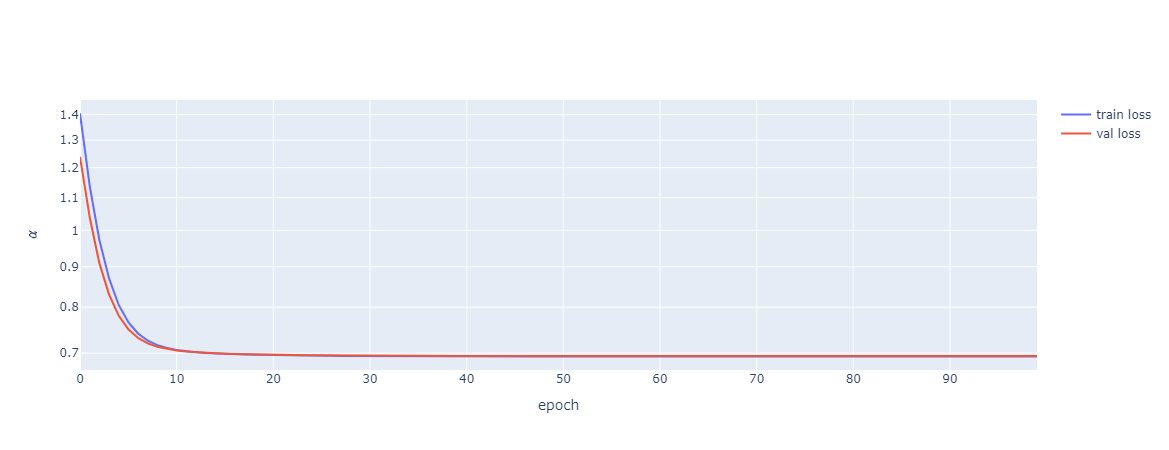

In [175]:
plot_history(slstm_history, label="loss")

In [176]:
evaluate_model_uv(slstm_model)

,Train,Validation,Test
loss,0.693033,0.693903,0.691889
entropy,0.693032,0.693902,0.691889
acc,50.620687,47.963801,54.260087


## LSTM + Conv1D

Here we use a 1D Convolutional layer.

In [206]:
def get_simple_conv1d_lstm_model(nx, ny):
    
    l2 = tf.keras.regularizers.l2(0.005)
    
    inputs = tf.keras.layers.Input(shape=[None, nx])
    
    X = tf.keras.layers.Conv1D(filters=5, kernel_size=5, strides=1, padding="causal", 
                               activation="elu", kernel_regularizer=l2)(inputs)
    X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24, kernel_regularizer=l2, 
                                                           return_sequences=False))(X)
    X = tf.keras.layers.Dropout(0.2)(X)
    outputs = tf.keras.layers.Dense(ny, kernel_regularizer=l2, activation=tf.nn.softmax)(X)
    
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    
    return model

In [187]:
print("For Conv1D layer")
print("#weight parameters = ", (5*32))
print("#bias parameters = ", 32 )
print("Total number of parameters = ", (5*32)+32)

For Conv1D layer
#weight parameters =  160
#bias parameters =  32
Total number of parameters =  192


In [472]:
tf.keras.backend.clear_session()

with tf.device(gpu[0].name):
    
    conv1d_model = get_simple_conv1d_lstm_model(nx=1, ny=2)
    
    conv1d_history, conv1d_model = run_model_uv(conv1d_model, epochs=100, lr0=2e-3,
                                                lr_min=1e-4, s=25, decay=1.15,
                                                use_callbacks=True, verbose=0)

Training Started
Training Complete


From the summary below increasing the number of filters increases the "dimensionality" of the output from the conv1d and into the LSTM. \
Hence at each time step the LSTM cell is recieves an input with shape (batch size, No.filters).

In [202]:
conv1d_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 1)]         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 10)          60        
_________________________________________________________________
bidirectional (Bidirectional (None, 32)                3456      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 2)                 66        
Total params: 3,582
Trainable params: 3,582
Non-trainable params: 0
_________________________________________________________________


we also note the weights matrix is of shape **(kernel_size, 1, No.filters)**. \
Each filter has 1 bias term so the bias vecotr should be of shape (No.filters)

In [203]:
conv1d_model.layers[1].get_weights()[0].shape

(5, 1, 10)

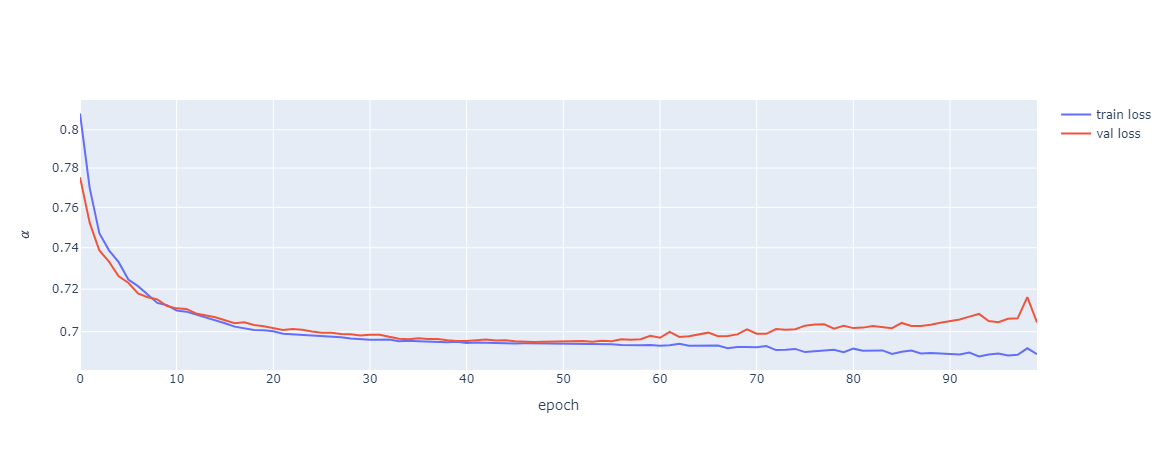

In [208]:
plot_history(conv1d_history, label="loss")

I have not tried to make an optimal model here, rather illustrating how a 1D convolution can \
added into a model and the effect on the input to the LSTM layer. \
In the above figure the validation loss diverges significantly from the training loss after approximately 60 epochs, \
and from the training loss it can be noted that the model has not yet fully converged. \

The model appears to be overfitting significantly and no regularization has been added to the model's as of yet.

In [210]:
evaluate_model_uv(conv1d_model)

,Train,Validation,Test
loss,0.686925,0.704317,0.693486
entropy,0.683562,0.700953,0.690123
acc,56.000000,45.701358,56.053811


The above table confirms what the previous figured showed, that the model is overfitting the training data and generalizing poorly to the validation dataset. \
Howver, it appears to do well on the test dataset. The model has not finished training and it no further conclusions should be drawn from these results.

# Multivariate Time Series

I will now add additional indicators to the time series we are predicting on. \
Before this however we will look at how a multivariate time series is prepared and trained.

## Creation and Prediction of a Multivariate Time Series

First I will explore how to create a multivariate time series. \
We can do this by creating a 2D numpy array when we have a multivariate time series of dimensionality=2 \
i.e. each column is its own feature/explanatory variable/factor/predictor

In [211]:
data = np.stack([np.arange(20), np.arange(20) + 10], axis=1)
data.shape

(20, 2)

In [212]:
data[:2]

array([[ 0, 10],
       [ 1, 11]])

In [214]:
dataset = tf.data.Dataset.from_tensor_slices(data)

for item in dataset:
    print(item)
    break

tf.Tensor([ 0 10], shape=(2,), dtype=int32)


From the above we can see that each **"element"** of the data set is a **vector** of size=2 .\
Hence the`Dataset.from_tensor_slices(...)` method creates Tensors via slicing along the *rows* (1st dimension) of the array passed into it.

If we create a sliding window of shift=1 using this multivariate dataset, it should **slide** along the **rows** of the original dataset \
as this corresponds to sliding along the elements of the `tf.data.Dataset` object.

In [215]:
dataset2 = dataset.window(size=3, shift=1, drop_remainder=True)

for i, nested_ds in enumerate(dataset2):
    for j, element in enumerate(nested_ds):
        print(f"Window {i} - Element {j} = ", end="")
        print(element.numpy())
    print()
    if i == 2:
        break

Window 0 - Element 0 = [ 0 10]
Window 0 - Element 1 = [ 1 11]
Window 0 - Element 2 = [ 2 12]

Window 1 - Element 0 = [ 1 11]
Window 1 - Element 1 = [ 2 12]
Window 1 - Element 2 = [ 3 13]

Window 2 - Element 0 = [ 2 12]
Window 2 - Element 1 = [ 3 13]
Window 2 - Element 2 = [ 4 14]



Each window is actually a `Dataset` instance object, hence the dataset2 variable is actually a nested dataset. \
As in previous univariate example we can unroll the nested dataset via using "flat_map" and within the lambda function calling the \
`Dataset.batch(...)` method with batch size = window size

In [216]:
dataset3 = dataset2.flat_map(lambda window: window.batch(3))

for i, element in enumerate(dataset3):
    print(f"Element {i} = ", end="")
    print(element.numpy().shape)
    print()
    
    if i == 2:
        break

Element 0 = (3, 2)

Element 1 = (3, 2)

Element 2 = (3, 2)



Now each element of the dataset is a 2d numpy array with,
+ number of rows = window_size
+ number of colums = dimensionality/No. features/explanatory variables/exogenous variables/predictors/factors (whatever you want to call them)


Hence in the next sub-section we can create a function that takes in a 2D array and creates a datasat for use in training the model. \
The most important/only change to this from the previous function is that when we split the windows into X, y we must select a specific column to use as the \
target variable. In other words we must ensure that shape of y is $[m, 1]$ and not $[m, dimensionality]$. \
After one-got encoding this will be shape $[m, No.classes]$

In [217]:
def window_dataset_multivariate(mv_data, window_size, batch_size, shuffle_buffer, target_col, repeat=0, prefetch=0):
    """
    Returns a dataset where each element is (X, y) tensors.
    For each training instance X is a sequence and y is a scalar value, hence this is a sequence-vector ML problem
    param mv_data:         DataFrame or 2D array where columns are predictors and rows as samples points / time axis
    param window_size:     This will be the number of elements that we will use as our features in each sequence
    param batch_size:      This is the batch size to be fed into the model
    param shuffle_buffer:  See docs for mechanics of shuffle buffer
    
    returns: tf.data.Dataset where each element is a tuple of (X, y) where shape of arrays in tuple are,
             X - [batch_size, window_size, n_cols in mv_data]
             y - [batch_size, 1]
    """
    
    overall_window = window_size + 1 # add extra 1 to sequence length to account for last value been target y
    
    depth = len(np.unique(mv_data[:, target_col]))
    
    # First we convert the series of values into a Dataset object
    dataset = tf.data.Dataset.from_tensor_slices(mv_data)
    
    # Window the data and then flatten the nested windows
    dataset = dataset.window(size=overall_window, shift=1, drop_remainder=True)
    
    dataset = dataset.flat_map(lambda window: window.batch(overall_window))
    
    if repeat:
        dataset = dataset.repeat(repeat) # ensure repeat is called before shuffle
    
    # Shuffle and use map to make each element of final Dataset a tuple of (X, y)
    # NOTE: select the column from 'y' to use as predicted/target value
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1, :], tf.one_hot(tf.cast(window[-1, target_col], dtype=tf.int32), depth=depth)))

    # Create batches for mini-batch gradient descent
    dataset = dataset.batch(batch_size)
    
    if prefetch:
        dataset = dataset.prefetch(prefetch)
    
    return dataset

In [229]:
def run_model_mv(model, epochs=500, lr0=1e-3, s=50, decay=10, lr_min=None, verbose=1,
              loss=None, opt=None, metrics=None, callbacks=None, use_callbacks=True, comp=True):
    """
    Helper function for training only on the multivariate time series dataset.
    """
    output = run_model(
        model=model, ds_train=train_mv_dataset, ds_val=val_mv_dataset,
        epochs=epochs, verbose=verbose, lr0=lr0, s=s, decay=decay, lr_min=lr_min, 
        loss=loss, opt=opt, metrics=metrics, 
        callbacks=callbacks, use_callbacks=use_callbacks, comp=comp)
    
    return output

def evaluate_model_mv(model):
    """
    Helpher function for evaluating the multivariate time series dataset.
    """
    return evaluate_model(model, train_mv_dataset, val_mv_dataset, test_mv_dataset)

In [220]:
def get_dataframe_maps(df):
    import itertools as it
    
    index_to_col = dict(zip(it.count(start=0, step=1), df.columns))
    
    col_to_index = dict(zip(df.columns, it.count(start=0, step=1)))
    
    return index_to_col, col_to_index

## Prediction of Multivariate Time Series

As with previous sections, I will start off with a basic indicator (simple moving average) and show how we can train a model with this. \
Following this I will add more indicators and use more complex models.

In [218]:
df_ml_mv = df_clean_dict[symbol_list[0]].copy()
df_ml_mv.head()

,open,high,low,close,volume
date,,,,,
2015-06-15,22.21,22.76,21.83,22.71,1022248
2015-06-16,22.75,22.94,22.48,22.63,625769
2015-06-17,22.70,23.00,22.48,22.88,844558
2015-06-18,23.00,25.15,22.86,24.42,2820323
2015-06-19,25.50,25.56,23.50,23.78,2364291


In [219]:
df_ml_mv["sma_20"] = df_ml_mv[PCLOSE].rolling(20).mean()
get_returns_data(df_ml_mv)
df_ml_mv.dropna(inplace=True)

In [221]:
index_to_col, _ = get_dataframe_maps(df_ml_mv)
display(index_to_col)

{0: 'open',
 1: 'high',
 2: 'low',
 3: 'close',
 4: 'volume',
 5: 'sma_20',
 6: 'return',
 7: 'session_delta',
 8: 'return_sign',
 9: 'session_sign'}

In [222]:
selected_cols = [PCLOSE, "sma_20", "return_sign"]

df_ml_mv[selected_cols].head()

,close,sma_20,return_sign
date,,,
2015-07-13,21.76,22.6870,1
2015-07-14,22.50,22.6765,1
2015-07-15,21.98,22.6440,0
2015-07-16,22.69,22.6345,1
2015-07-17,23.54,22.5905,1


Split the multivariate data and time index (the `split_series` function requires no changes to it to account for multivariate data)

In [223]:
train_mv_series, val_mv_series, test_mv_series = split_series(df_ml_mv[selected_cols].values, train_ratio=0.6, val_ratio=0.2)
train_mv_time, val_mv_time, test_mv_time = split_series(df_ml_mv.index.values, train_ratio=0.6, val_ratio=0.2)

Check ratios

In [224]:
size = df_ml_mv.index.size
(
    round(train_mv_series.shape[0] / size, 3),
    round(val_mv_series.shape[0] / size, 3),
    round(test_mv_series.shape[0] / size, 3)
)

(0.6, 0.2, 0.2)

In [225]:
# User settings
window_size = 30
batch_size = 32
shuffle_buffer = 100

target_col = 2
# 
train_mv_dataset = window_dataset_multivariate(
    mv_data=train_mv_series, 
    window_size=window_size,
    batch_size=batch_size,
    shuffle_buffer=shuffle_buffer,
    target_col=target_col
)

val_mv_dataset = window_dataset_multivariate(
    mv_data=val_mv_series, 
    window_size=window_size,
    batch_size=batch_size,
    shuffle_buffer=shuffle_buffer,
    target_col=target_col
)

test_mv_dataset = window_dataset_multivariate(
    mv_data=test_mv_series, 
    window_size=window_size,
    batch_size=batch_size,
    shuffle_buffer=shuffle_buffer,
    target_col=target_col
)
for X, y in train_mv_dataset:
    print(X.numpy().shape, y.numpy().shape)
    break

(32, 30, 3) (32, 2)


At each time step, $X^{<t>}$ is of shape [batch size, dimensionality] = [32, 2] for multivariate time series with "close" and "ma" for dimensionality

hence weight matrix (**W**) will be of shape $[2, n^{[L]}]$ and bias is of shape $[1, n^{[L]}]$ where bias is broadcast to have shape $[m, n^{[L]}]$

Linear function for simple RNN is given by
$$
Z^{<t>} = X^{<t>} W_{ax}^T  + A^{<t-1>[L]} W_{aa}^T + b_a
$$

where $Z^{<t>}$ has shape of $[m, n^{[L]}]$ and more generally,

$$
Z^{<t>[L]} = A^{<t>[L-1]} W^{[L]}  + A^{<t-1>[L]} W_{aa}^T + b_a^{[L]}
$$

Activation for simple RNN given by,

$$
A^{<t>} = g(W_{ay}*Z^{<t>} + b_y^[L])
$$

where $g()$ is an activation function (usually tanh for RNN's rather than relu)

In [227]:
tmp_model = get_dnn_model(nx=len(selected_cols), ny=2)
tmp_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 30, 3)]           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 90)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 20)                1820      
_________________________________________________________________
dense_6 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_7 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 12        
Total params: 2,097
Trainable params: 2,097
Non-trainable params: 0
_________________________________________________________

Note that the output shape of (None, 90) from the Flatten layer corresponds to (batch_szie, 90). \
the number of columns (90) is equal to $\text{window size} \times \text{dimensionality}$

In [236]:
tf.keras.backend.clear_session()

with tf.device(gpu[0].name):
    
    dnn_mv_model = get_dnn_model(nx=len(selected_cols), ny=2)
    
    dnn_mv_history, dnn_mv_model = run_model_mv(dnn_mv_model, epochs=200, lr0=2.5e-5, use_callbacks=False, verbose=0)

Training Started
Training Complete


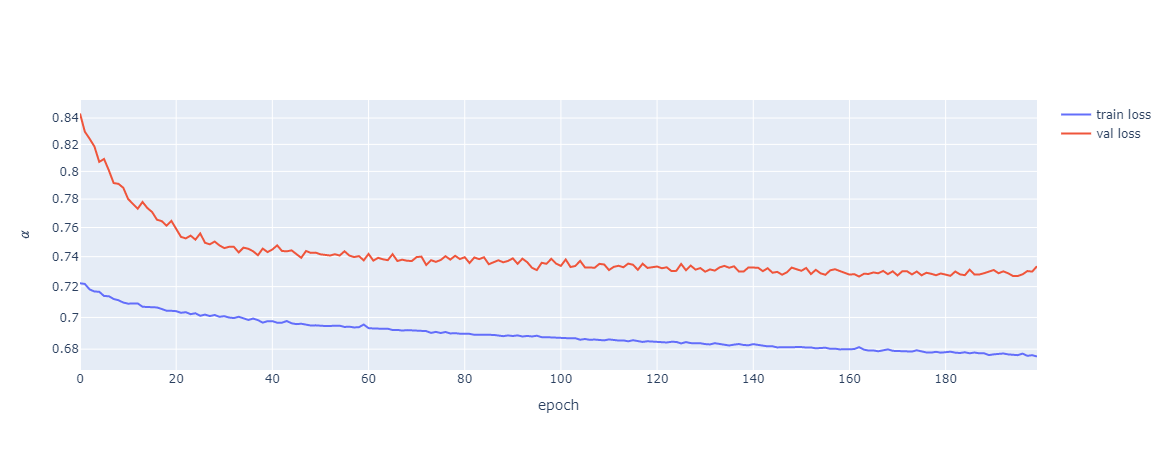

In [237]:
plot_history(dnn_mv_history, label="loss")

In [238]:
evaluate_model_mv(dnn_mv_model)

,Train,Validation,Test
loss,0.674915,0.730422,0.774990
entropy,0.674915,0.730422,0.774990
acc,57.563025,47.706422,44.954127


# Adding Indicators

Here we make use of 3 indicators

+ RSI
+ Stochastic %K, %D
+ Bollinger Bands

In [239]:
def get_rsi(df, period=14, regions=[0.7, 0.3]):

    def calc_rsi(data):

        returns = data.diff(periods=1)

        up_moves = returns[returns > 0].values
        down_moves = returns[ returns < 0].abs().values

        avg_up = up_moves.mean()
        avg_down = down_moves.mean()

        # Calculate the Relative Strength
        RS = avg_up/avg_down

        # Calculate Relative Stength Index
        # RSI = 100 - 100 / ( 1 + RS)

        RSI = 1 - 1 / ( 1 + RS)
        return RSI
    
    df[f"rsi_{period}_period"] = df[PCLOSE].rolling(period+1).apply(calc_rsi)
    
    overbought_threshold = max(regions)
    oversold_threshold = min(regions)
    
    df[f"rsi_{period}_overbought"] = (df[f"rsi_{period}_period"] >= overbought_threshold).astype(np.int32)
    df[f"rsi_{period}_oversold"] = (df[f"rsi_{period}_period"] <= oversold_threshold).astype(np.int32)
    return df

def get_bb(df, z=2, period=20):
    
    bb_std = df[[PCLOSE]].rolling(window=period).std()
    bb_sma = df[[PCLOSE]].rolling(window=period).mean()
    
    bb_lower = bb_sma - z*bb_std
    bb_upper = bb_sma + z*bb_std
    
    # Show where price is in relation to the bollinger bands
    bb_ploc = (df[[PCLOSE]] - bb_lower) / (bb_upper - bb_lower)
    
    df[f"bb_{z}_std"] = bb_std
    df[f"bb_{period}_sma"] = bb_sma
    df[f"bb_ploc_{z}std"] = bb_ploc
    
    return df

def get_stochastic_indicator(df, p1=14, p2=3, regions=[0.7, 0.3]):
    # need to use numpy apply or else Dataframe.apply will do it on a per column basis
    high = df[[PCLOSE, POPEN, PLOW, PHIGH]].rolling(p1).max().max(axis=1)
    low = df[[PCLOSE, POPEN, PLOW, PHIGH]].rolling(p1).min().min(axis=1)
    
    percentage_k = (df[PCLOSE] - low) / (high - low)
    
    percentage_d = percentage_k.rolling(p2).mean()
    
    df["%k"] = percentage_k
    df["%d"] = percentage_d
    
    overbought_threshold = max(regions)
    oversold_threshold = min(regions)
    
    # Overbought and Oversold regions
    df["stochastic_overbought"] = (percentage_d >= overbought_threshold).astype(np.int32)
    df["stochastic_oversold"] = (percentage_d <= oversold_threshold).astype(np.int32)
    
    return df

We make use of a new dataframe containing these inidcators.

In [240]:
df_ml_ind = df_clean_dict[symbol_list[0]].copy()
df_ml_ind.head()

,open,high,low,close,volume
date,,,,,
2015-06-15,22.21,22.76,21.83,22.71,1022248
2015-06-16,22.75,22.94,22.48,22.63,625769
2015-06-17,22.70,23.00,22.48,22.88,844558
2015-06-18,23.00,25.15,22.86,24.42,2820323
2015-06-19,25.50,25.56,23.50,23.78,2364291


In [241]:
get_stochastic_indicator(df_ml_ind, p1=14, p2=3, regions=[0.8, 0.2]);

In [242]:
get_rsi(df_ml_ind, period=14);

In [243]:
get_bb(df_ml_ind, z=2, period=20);

In [244]:
get_returns_data(df_ml_ind);

In [245]:
df_ml_comp = df_ml_ind.dropna()
df_ml_comp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1240 entries, 2015-07-13 to 2020-06-12
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   open                   1240 non-null   float64
 1   high                   1240 non-null   float64
 2   low                    1240 non-null   float64
 3   close                  1240 non-null   float64
 4   volume                 1240 non-null   int64  
 5   %k                     1240 non-null   float64
 6   %d                     1240 non-null   float64
 7   stochastic_overbought  1240 non-null   int32  
 8   stochastic_oversold    1240 non-null   int32  
 9   rsi_14_period          1240 non-null   float64
 10  rsi_14_overbought      1240 non-null   int32  
 11  rsi_14_oversold        1240 non-null   int32  
 12  bb_2_std               1240 non-null   float64
 13  bb_20_sma              1240 non-null   float64
 14  bb_ploc_2std           1240 non-null  

In [246]:
df_ml_comp.describe().T[["min", "max"]]

,min,max
open,8.220000,3.498000e+01
high,8.340000,3.513000e+01
low,7.860000,3.327000e+01
close,8.210000,3.430000e+01
volume,120149.000000,8.482205e+06
%k,0.000000,1.000000e+00
%d,0.021474,9.892576e-01
stochastic_overbought,0.000000,1.000000e+00
stochastic_oversold,0.000000,1.000000e+00
rsi_14_period,0.184222,9.000000e-01


## Convert to Dataset

Find the column index values

In [247]:
index_to_col, col_to_index = get_dataframe_maps(df_ml_comp)
index_to_col

{0: 'open',
 1: 'high',
 2: 'low',
 3: 'close',
 4: 'volume',
 5: '%k',
 6: '%d',
 7: 'stochastic_overbought',
 8: 'stochastic_oversold',
 9: 'rsi_14_period',
 10: 'rsi_14_overbought',
 11: 'rsi_14_oversold',
 12: 'bb_2_std',
 13: 'bb_20_sma',
 14: 'bb_ploc_2std',
 15: 'return',
 16: 'session_delta',
 17: 'return_sign',
 18: 'session_sign'}

In [261]:
selected_cols = [3] + list(np.arange(start=4, stop=18))
{k:index_to_col[k] for k in selected_cols}

{3: 'close',
 4: 'volume',
 5: '%k',
 6: '%d',
 7: 'stochastic_overbought',
 8: 'stochastic_oversold',
 9: 'rsi_14_period',
 10: 'rsi_14_overbought',
 11: 'rsi_14_oversold',
 12: 'bb_2_std',
 13: 'bb_20_sma',
 14: 'bb_ploc_2std',
 15: 'return',
 16: 'session_delta',
 17: 'return_sign'}

In [262]:
target_col = col_to_index["return_sign"]
target_col

17

In [263]:
s = set(selected_cols)
s.remove(target_col)
s = list(s)
s.insert(0, target_col)

corr_columns = s

print(corr_columns)

[17, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


In [264]:
uniques, counts = np.unique(df_ml_comp.values[:, target_col], return_counts=True)

In [265]:
list(zip(uniques, counts))

[(0.0, 607), (1.0, 633)]

In [266]:
df_ml_comp.iloc[:, s].isna().sum()

return_sign              0
close                    0
volume                   0
%k                       0
%d                       0
stochastic_overbought    0
stochastic_oversold      0
rsi_14_period            0
rsi_14_overbought        0
rsi_14_oversold          0
bb_2_std                 0
bb_20_sma                0
bb_ploc_2std             0
return                   0
session_delta            0
dtype: int64

In [267]:
train_mv_series, val_mv_series, test_mv_series = split_series(df_ml_comp.iloc[:, corr_columns].values, train_ratio=0.6, val_ratio=0.2)
train_mv_time, val_mv_time, test_mv_time = split_series(df_ml_comp.index.values, train_ratio=0.6, val_ratio=0.2)

Training, Validation and Testing Datasets are created that containing indicators

In [268]:
# User settings
window_size = 30
batch_size = 32
shuffle_buffer = 100

target_col = 0
# 
train_mv_dataset = window_dataset_multivariate(
    mv_data=train_mv_series, 
    window_size=window_size,
    batch_size=batch_size,
    shuffle_buffer=shuffle_buffer,
    target_col=target_col
)

val_mv_dataset = window_dataset_multivariate(
    mv_data=val_mv_series, 
    window_size=window_size,
    batch_size=batch_size,
    shuffle_buffer=shuffle_buffer,
    target_col=target_col
)

test_mv_dataset = window_dataset_multivariate(
    mv_data=test_mv_series, 
    window_size=window_size,
    batch_size=batch_size,
    shuffle_buffer=shuffle_buffer,
    target_col=target_col
)

for X, y in train_mv_dataset:
    print(X.numpy().shape, y.numpy().shape)
    break

(32, 30, 15) (32, 2)


## Train Dense Network

In [269]:
tmp_model = get_dnn_model(nx=len(selected_cols), ny=2)
tmp_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 30, 15)]          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 450)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 20)                9020      
_________________________________________________________________
dense_5 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 12        
Total params: 9,297
Trainable params: 9,297
Non-trainable params: 0
_________________________________________________________

In [275]:
tf.keras.backend.clear_session()

with tf.device(gpu[0].name):
    
    dnn_mv_model = get_dnn_model(nx=len(selected_cols), ny=2)
    
    dnn_mv_history, dnn_mv_model = run_model_mv(dnn_mv_model, epochs=100, lr0=1e-4, use_callbacks=False, verbose=0)

Training Started
Training Complete


In [276]:
evaluate_model_mv(dnn_mv_model)

,Train,Validation,Test
loss,0.685441,2860.279912,380.394542
entropy,0.685441,2860.279785,380.394562
acc,50.840336,47.247708,53.211010


## Train RNN

In [277]:
tf.keras.backend.clear_session()

with tf.device(gpu[0].name):
     
    srnn_mv_model = get_simple_rnn_model(nx=len(selected_cols), ny=2)
    
    srnn_mv_history, srnn_mv_model = run_model_mv(srnn_mv_model, epochs=100, lr0=1e-4, use_callbacks=False, verbose=0)

Training Started
Training Complete


In [278]:
evaluate_model_mv(srnn_mv_model)

,Train,Validation,Test
loss,0.797527,0.801616,0.791214
entropy,0.700748,0.704837,0.694435
acc,50.420171,49.082568,53.211010


## Main LSTM model

### Model 1

In [427]:
def get_lstm_model1(nx, ny):
    
    l2_a = tf.keras.regularizers.l2(0.05)
    l2_b = tf.keras.regularizers.l2(0.01)
    l2_c = tf.keras.regularizers.l2(0.005)
    
    # Input Layer
    inputs = tf.keras.layers.Input(shape=[window_size, nx])
    
    # First Recurrent Layer
    X = tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization())(inputs)  # feature normalization is learnt here
    X = tf.keras.layers.Conv1D(filters=20, kernel_size=5, strides=1, padding="causal",
                               kernel_regularizer=l2_c, activation=tf.nn.elu,
                               kernel_initializer="he_normal")(X)
    X = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(units=12, kernel_regularizer=None, return_sequences=True))(X)
    
    X = tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(0.2))(X)
    
    # Second Recurrent Layer
    X = tf.keras.layers.LSTM(units=12, kernel_regularizer=l2_c, return_sequences=False)(X)
    X = tf.keras.layers.Dropout(0.2)(X)
    
    # Output Dense Network
    X = tf.keras.layers.Dense(10, kernel_regularizer=l2_c, activation=tf.nn.elu, kernel_initializer="he_normal")(X)
    outputs = tf.keras.layers.Dense(ny, kernel_regularizer=None, activation=tf.nn.softmax)(X)
    
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    
    return model

In [418]:
tf.keras.backend.clear_session()
tmp = get_lstm_model1(nx=len(selected_cols), ny=2)
tmp.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30, 15)]          0         
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 15)            60        
_________________________________________________________________
conv1d (Conv1D)              (None, 30, 20)            920       
_________________________________________________________________
bidirectional (Bidirectional (None, 30, 24)            3168      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 24)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 12)                1776      
_________________________________________________________________
dense (Dense)                (None, 10)                130   

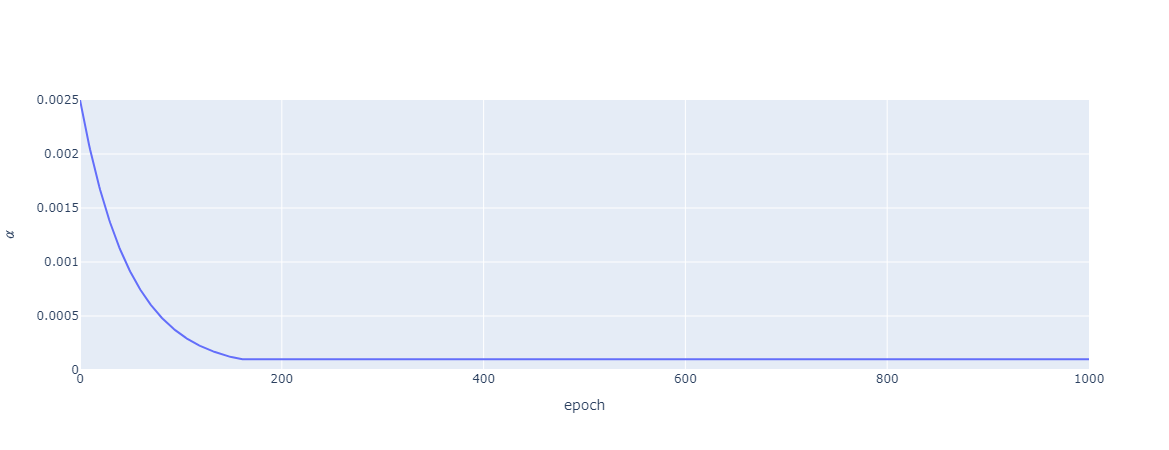

In [326]:
plot_learning_schedule(exponential_decay(lr0=2.5e-3, lr_min=1e-4, s=20, decay=1.5), epochs=1000)

In [429]:
##### tf.keras.backend.clear_session()

with tf.device(gpu[0]):
    
    lstm_mv_model1 = get_lstm_model1(nx=len(selected_cols), ny=2)
    
    lstm_mv_history1, lstm_mv_model1 = run_model_mv(
        lstm_mv_model1, 
        epochs=200,
        lr0=2.5e-3, s=20, decay=1.5, lr_min=1e-4,
        use_callbacks=True,
        verbose=0)

Training Started
Training Complete


In [430]:
lstm_mv_model1.metrics_names

['loss', 'entropy', 'acc']

In [431]:
lstm_mv_history1.history.keys()

dict_keys(['loss', 'entropy', 'acc', 'val_loss', 'val_entropy', 'val_acc', 'lr'])

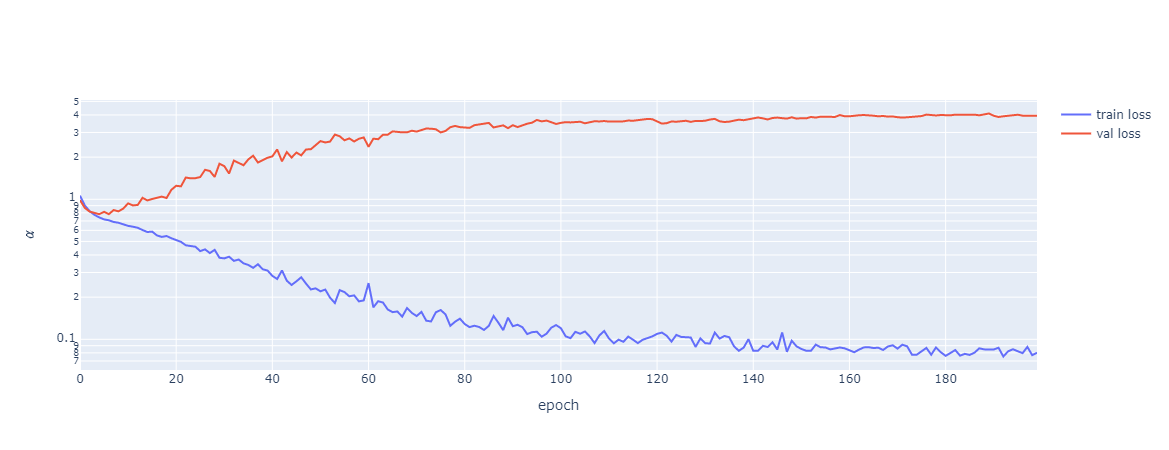

In [432]:
plot_history(lstm_mv_history1, label="loss")

In [436]:
evaluate_model_mv(lstm_mv_model1)

,Train,Validation,Test
loss,0.066529,4.009482,3.491952
entropy,0.008005,3.950958,3.433428
acc,99.719888,51.376146,55.504584


### Model 2

In [452]:
def get_lstm_model2(nx, ny):
    
    l2_a = tf.keras.regularizers.l2(0.05)
    l2_b = tf.keras.regularizers.l2(0.01)
    l2_c = tf.keras.regularizers.l2(0.005)
    
    # Input Layer
    inputs = tf.keras.layers.Input(shape=[window_size, nx])
    
    # First Recurrent Layer
    X = tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization())(inputs) 
    X = tf.keras.layers.Conv1D(filters=20, kernel_size=10, strides=1, padding="causal",
                               kernel_regularizer=l2_c, activation=tf.nn.elu,
                               kernel_initializer="he_normal")(X)
    X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=34, kernel_regularizer=None, return_sequences=True))(X)
    X = tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(0.3))(X)
    
    # Second Recurrent Layer
    X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=16, kernel_regularizer=None, return_sequences=True))(X)
    X = tf.keras.layers.Dropout(0.2)(X)
    
    # Third Recurrent layer
    X = tf.keras.layers.LSTM(units=16, kernel_regularizer=l2_c, return_sequences=False)(X)
    X = tf.keras.layers.Dropout(0.1)(X)
   
    # Output Dense Network
    X = tf.keras.layers.Dense(16, kernel_regularizer=l2_c, activation=tf.nn.elu)(X)
    X = tf.keras.layers.Dense(8, kernel_regularizer=l2_c, activation=tf.nn.elu)(X)
    outputs = tf.keras.layers.Dense(ny, kernel_regularizer=l2_c, activation=tf.nn.softmax)(X)
    
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    
    return model

In [453]:
tf.keras.backend.clear_session()
tmp = get_lstm_model2(nx=len(selected_cols), ny=2)
tmp.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30, 15)]          0         
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 15)            60        
_________________________________________________________________
conv1d (Conv1D)              (None, 30, 20)            3020      
_________________________________________________________________
bidirectional (Bidirectional (None, 30, 68)            14960     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 30, 68)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 30, 32)            10880     
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 32)            0     

In [471]:
tf.keras.backend.clear_session()

with tf.device(gpu[0]):
    
    lstm_mv_model2 = get_lstm_model2(nx=len(selected_cols), ny=2)
    
    lstm_mv_history2, lstm_mv_model2 = run_model_mv(
        lstm_mv_model2, 
        epochs=200,
        lr0=2.5e-3, s=20, decay=1.5, lr_min=1e-4,
        use_callbacks=True,
        verbose=0)

Training Started
Training Complete


In [455]:
lstm_mv_model2.metrics_names

['loss', 'entropy', 'acc']

In [456]:
lstm_mv_history2.history.keys()

dict_keys(['loss', 'entropy', 'acc', 'val_loss', 'val_entropy', 'val_acc', 'lr'])

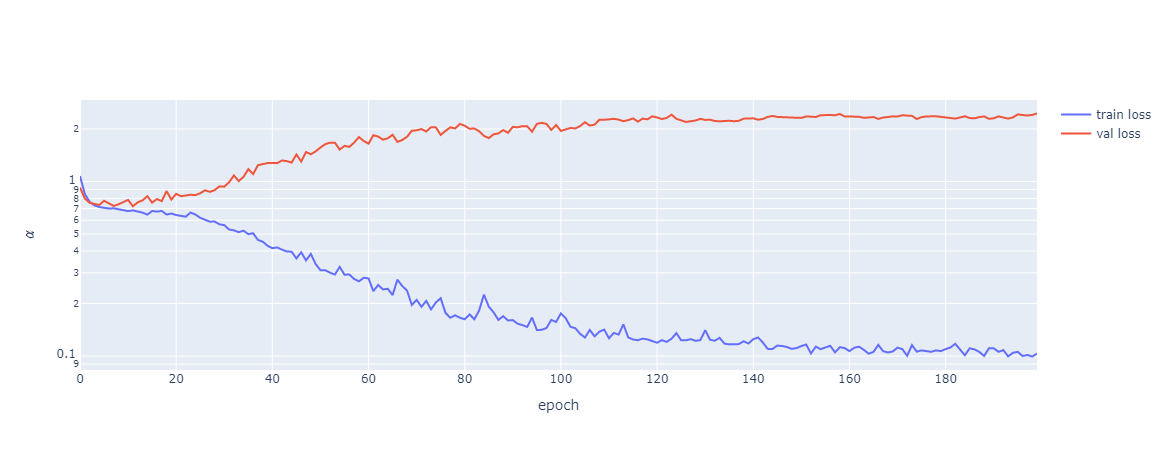

In [457]:
plot_history(lstm_mv_history2, label="loss")

In [458]:
evaluate_model_mv(lstm_mv_model2)

,Train,Validation,Test
loss,0.093319,2.457487,2.532469
entropy,0.018381,2.382548,2.457530
acc,99.579829,50.917429,52.293581


### Model 3

In [459]:
def get_lstm_model3(nx, ny):
    
    l2 = tf.keras.regularizers.l2(0.005)
    
    # Input Layer
    inputs = tf.keras.layers.Input(shape=[window_size, nx])
    
    # First Recurrent Layer
    X = tf.keras.layers.TimeDistributed(tf.keras.layers.BatchNormalization())(inputs)  # feature normalization is learnt here
    X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=8, kernel_regularizer=l2, return_sequences=True))(X)
    #X = tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(0.2))(X)
    
    # Second Recurrent Layer
    X = tf.keras.layers.LSTM(units=8, kernel_regularizer=l2, return_sequences=False)(X)
   
    # Output Dense Network
    #X = tf.keras.layers.Dense(32, kernel_regularizer=l2, activation=tf.nn.elu)(X)
    X = tf.keras.layers.Dense(6, kernel_regularizer=l2, activation=tf.nn.elu)(X)
    outputs = tf.keras.layers.Dense(ny, kernel_regularizer=l2, activation=tf.nn.softmax)(X)
    
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    
    return model

In [460]:
tf.keras.backend.clear_session()
tmp = get_lstm_model3(nx=len(selected_cols), ny=2)
tmp.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 30, 15)]          0         
_________________________________________________________________
time_distributed (TimeDistri (None, 30, 15)            60        
_________________________________________________________________
bidirectional (Bidirectional (None, 30, 16)            1536      
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 800       
_________________________________________________________________
dense (Dense)                (None, 6)                 54        
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 14        
Total params: 2,464
Trainable params: 2,434
Non-trainable params: 30
__________________________________________________________

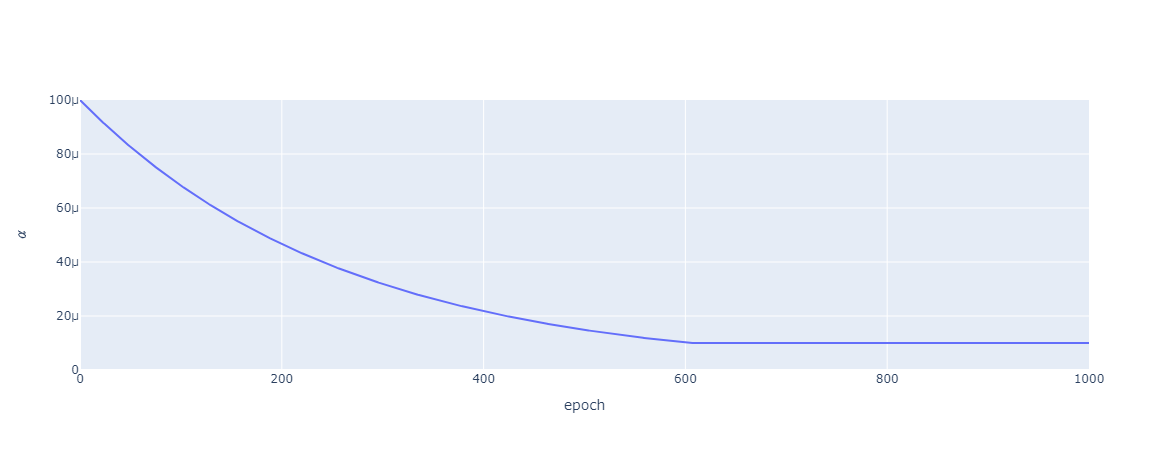

In [461]:
plot_learning_schedule(exponential_decay(lr0=1e-4, s=25, decay=1.1, lr_min=1e-5), epochs=1000)

In [470]:
tf.keras.backend.clear_session()

with tf.device(gpu[0]):
    
    lstm_mv_model3 = get_lstm_model3(nx=len(selected_cols), ny=2)
    
    lstm_mv_history3, lstm_mv_model3 = run_model_mv(
        lstm_mv_model3, 
        epochs=200,
        lr0=1e-4, s=25, decay=1.2, lr_min=1e-6,
        use_callbacks=False,
        verbose=0)

Training Started
Training Complete


In [465]:
lstm_mv_model3.metrics_names

['loss', 'entropy', 'acc']

In [466]:
lstm_mv_history3.history.keys()

dict_keys(['loss', 'entropy', 'acc', 'val_loss', 'val_entropy', 'val_acc'])

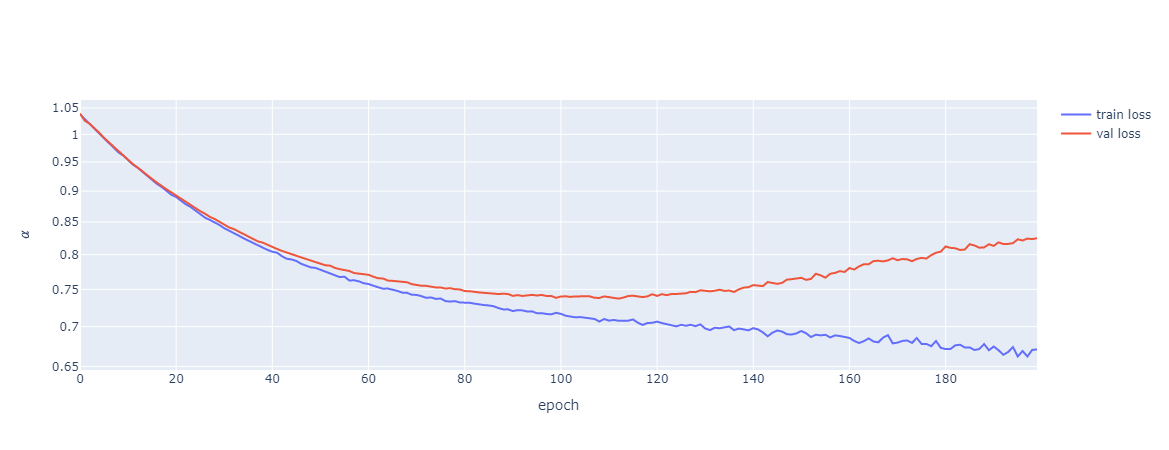

In [468]:
plot_history(lstm_mv_history3, label="loss")

The figure above shows that the model is overfitting ans after ~100 epochs the validation error starts to steadily increase. Either some form of additional regularization or early stopping can be used to prevent the model from overfitting further.

In [469]:
evaluate_model_mv(lstm_mv_model3)

,Train,Validation,Test
loss,0.668264,0.825333,0.816116
entropy,0.632927,0.789996,0.780779
acc,63.725489,51.376146,52.293581


# Conclusion

+ I have demonstrated how a multivariate dataset that can be passed into a model can be created.
+ I have illustrated ,using fully connected dense layers, recurrent layers and Convolutional layers, how various types of neural networks \
can be setup and trained to predict sequential data.
+ I have demonstrated how learning rates can be adjusted during the course of training via callbacks

+ I have not gone indepth into hyperparameter tuning due to computational and time constraints, but l2 regularization was used and dropout \
to attempt to reduce model overfitting.


The models here ahcieved a peak performance of 55% accuracy on the test dataset, however many of them were clearly overfitting to the training data \
and I will need to address this in the future via tunning hyperparameters and n_neurons used in the various layers.